In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 o7ee3ga8


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-o7ee3ga8:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.7


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                             | 0/5867 [00:00<?, ?it/s]

  0%|                                                                     | 1/5867 [00:00<55:25,  1.76it/s]

  0%|                                                                    | 10/5867 [00:00<05:06, 19.11it/s]

  0%|▏                                                                   | 18/5867 [00:00<03:01, 32.25it/s]

  0%|▎                                                                   | 27/5867 [00:00<02:07, 45.80it/s]

  1%|▍                                                                   | 36/5867 [00:00<01:43, 56.32it/s]

  1%|▌                                                                   | 45/5867 [00:01<01:30, 64.49it/s]

  1%|▋                                                                   | 54/5867 [00:01<01:22, 70.79it/s]

  1%|▋                                                                   | 63/5867 [00:01<01:16, 75.41it/s]

  1%|▊                                                                   | 72/5867 [00:01<01:13, 78.74it/s]

  1%|▉                                                                   | 81/5867 [00:01<01:11, 81.07it/s]

  2%|█                                                                   | 90/5867 [00:01<01:09, 82.82it/s]

  2%|█▏                                                                  | 99/5867 [00:01<01:08, 84.05it/s]

  2%|█▏                                                                 | 108/5867 [00:01<01:07, 84.81it/s]

  2%|█▎                                                                 | 117/5867 [00:01<01:07, 85.53it/s]

  2%|█▍                                                                 | 126/5867 [00:02<01:06, 85.83it/s]

  2%|█▌                                                                 | 135/5867 [00:02<01:06, 86.26it/s]

  2%|█▋                                                                 | 144/5867 [00:02<01:06, 86.34it/s]

  3%|█▋                                                                 | 153/5867 [00:02<01:06, 86.51it/s]

  3%|█▊                                                                 | 162/5867 [00:02<01:05, 86.57it/s]

  3%|█▉                                                                 | 171/5867 [00:02<01:05, 86.77it/s]

  3%|██                                                                 | 180/5867 [00:02<01:05, 86.64it/s]

  3%|██▏                                                                | 189/5867 [00:02<01:05, 86.64it/s]

  3%|██▎                                                                | 198/5867 [00:02<01:05, 86.41it/s]

  4%|██▎                                                                | 207/5867 [00:02<01:05, 86.37it/s]

  4%|██▍                                                                | 216/5867 [00:03<01:05, 86.40it/s]

  4%|██▌                                                                | 225/5867 [00:03<01:05, 86.49it/s]

  4%|██▋                                                                | 234/5867 [00:03<01:05, 86.46it/s]

  4%|██▊                                                                | 243/5867 [00:03<01:04, 86.73it/s]

  4%|██▉                                                                | 252/5867 [00:03<01:04, 86.53it/s]

  4%|██▉                                                                | 261/5867 [00:03<01:04, 86.50it/s]

  5%|███                                                                | 270/5867 [00:03<01:04, 86.39it/s]

  5%|███▏                                                               | 279/5867 [00:03<01:04, 86.38it/s]

  5%|███▎                                                               | 288/5867 [00:03<01:03, 87.18it/s]

  5%|███▍                                                               | 297/5867 [00:03<01:03, 87.83it/s]

  5%|███▍                                                               | 306/5867 [00:04<01:03, 88.22it/s]

  5%|███▌                                                               | 315/5867 [00:04<01:03, 87.68it/s]

  6%|███▋                                                               | 324/5867 [00:04<01:03, 87.74it/s]

  6%|███▊                                                               | 333/5867 [00:04<01:02, 88.29it/s]

  6%|███▉                                                               | 342/5867 [00:04<01:02, 88.55it/s]

  6%|████                                                               | 351/5867 [00:04<01:02, 88.65it/s]

  6%|████                                                               | 360/5867 [00:04<01:02, 88.80it/s]

  6%|████▏                                                              | 369/5867 [00:04<01:02, 88.59it/s]

  6%|████▎                                                              | 378/5867 [00:04<01:02, 88.26it/s]

  7%|████▍                                                              | 387/5867 [00:05<01:02, 87.70it/s]

  7%|████▌                                                              | 396/5867 [00:05<01:02, 87.59it/s]

  7%|████▋                                                              | 405/5867 [00:05<01:02, 87.52it/s]

  7%|████▋                                                              | 414/5867 [00:05<01:02, 87.56it/s]

  7%|████▊                                                              | 423/5867 [00:05<01:02, 87.32it/s]

  7%|████▉                                                              | 432/5867 [00:05<01:02, 87.23it/s]

  8%|█████                                                              | 441/5867 [00:05<01:02, 87.12it/s]

  8%|█████▏                                                             | 450/5867 [00:05<01:02, 87.12it/s]

  8%|█████▏                                                             | 459/5867 [00:05<01:01, 87.39it/s]

  8%|█████▎                                                             | 468/5867 [00:05<01:01, 87.33it/s]

  8%|█████▍                                                             | 477/5867 [00:06<01:01, 87.27it/s]

  8%|█████▌                                                             | 486/5867 [00:06<01:01, 87.16it/s]

  8%|█████▋                                                             | 495/5867 [00:06<01:01, 87.35it/s]

  9%|█████▊                                                             | 504/5867 [00:06<01:01, 87.51it/s]

  9%|█████▊                                                             | 513/5867 [00:06<01:01, 87.55it/s]

  9%|█████▉                                                             | 522/5867 [00:06<01:01, 87.53it/s]

  9%|██████                                                             | 531/5867 [00:06<01:01, 87.40it/s]

  9%|██████▏                                                            | 540/5867 [00:06<01:00, 87.47it/s]

  9%|██████▎                                                            | 549/5867 [00:06<01:00, 87.24it/s]

 10%|██████▎                                                            | 558/5867 [00:06<01:00, 87.12it/s]

 10%|██████▍                                                            | 567/5867 [00:07<01:00, 87.01it/s]

 10%|██████▌                                                            | 576/5867 [00:07<01:00, 87.06it/s]

 10%|██████▋                                                            | 585/5867 [00:07<01:00, 86.93it/s]

 10%|██████▊                                                            | 594/5867 [00:07<01:00, 87.30it/s]

 10%|██████▉                                                            | 603/5867 [00:07<01:00, 87.12it/s]

 10%|██████▉                                                            | 612/5867 [00:07<01:00, 87.16it/s]

 11%|███████                                                            | 621/5867 [00:07<01:00, 87.05it/s]

 11%|███████▏                                                           | 630/5867 [00:07<01:00, 87.03it/s]

 11%|███████▎                                                           | 639/5867 [00:07<01:00, 86.94it/s]

 11%|███████▍                                                           | 648/5867 [00:08<01:00, 86.95it/s]

 11%|███████▌                                                           | 657/5867 [00:08<00:59, 87.01it/s]

 11%|███████▌                                                           | 666/5867 [00:08<00:59, 87.09it/s]

 12%|███████▋                                                           | 675/5867 [00:08<00:59, 87.42it/s]

 12%|███████▊                                                           | 684/5867 [00:08<00:59, 87.30it/s]

 12%|███████▉                                                           | 693/5867 [00:08<00:59, 87.13it/s]

 12%|████████                                                           | 702/5867 [00:08<00:59, 86.27it/s]

 12%|████████                                                           | 711/5867 [00:08<00:59, 86.80it/s]

 12%|████████▏                                                          | 720/5867 [00:08<00:59, 86.89it/s]

 12%|████████▎                                                          | 729/5867 [00:08<00:59, 86.88it/s]

 13%|████████▍                                                          | 738/5867 [00:09<00:58, 87.17it/s]

 13%|████████▌                                                          | 747/5867 [00:09<00:58, 87.38it/s]

 13%|████████▋                                                          | 756/5867 [00:09<00:58, 87.29it/s]

 13%|████████▋                                                          | 765/5867 [00:09<00:58, 87.05it/s]

 13%|████████▊                                                          | 774/5867 [00:09<00:58, 87.00it/s]

 13%|████████▉                                                          | 783/5867 [00:09<00:58, 86.86it/s]

 13%|█████████                                                          | 792/5867 [00:09<00:58, 87.12it/s]

 14%|█████████▏                                                         | 801/5867 [00:09<00:58, 86.93it/s]

 14%|█████████▎                                                         | 810/5867 [00:09<00:58, 86.99it/s]

 14%|█████████▎                                                         | 819/5867 [00:09<00:58, 86.77it/s]

 14%|█████████▍                                                         | 828/5867 [00:10<00:57, 87.17it/s]

 14%|█████████▌                                                         | 837/5867 [00:10<00:57, 87.01it/s]

 14%|█████████▋                                                         | 846/5867 [00:10<00:57, 87.09it/s]

 15%|█████████▊                                                         | 855/5867 [00:10<00:57, 86.90it/s]

 15%|█████████▊                                                         | 864/5867 [00:10<00:57, 87.10it/s]

 15%|█████████▉                                                         | 873/5867 [00:10<00:57, 86.96it/s]

 15%|██████████                                                         | 882/5867 [00:10<00:56, 87.68it/s]

 15%|██████████▏                                                        | 891/5867 [00:10<00:56, 88.29it/s]

 15%|██████████▎                                                        | 900/5867 [00:10<00:56, 88.61it/s]

 16%|██████████▍                                                        | 910/5867 [00:11<00:55, 89.11it/s]

 16%|██████████▍                                                        | 919/5867 [00:11<00:55, 89.23it/s]

 16%|██████████▌                                                        | 928/5867 [00:11<00:55, 89.00it/s]

 16%|██████████▋                                                        | 937/5867 [00:11<00:55, 88.67it/s]

 16%|██████████▊                                                        | 946/5867 [00:11<00:55, 88.26it/s]

 16%|██████████▉                                                        | 955/5867 [00:11<00:55, 88.23it/s]

 16%|███████████                                                        | 964/5867 [00:11<00:55, 88.11it/s]

 17%|███████████                                                        | 973/5867 [00:11<00:55, 88.11it/s]

 17%|███████████▏                                                       | 982/5867 [00:11<00:55, 88.06it/s]

 17%|███████████▎                                                       | 991/5867 [00:11<00:55, 87.86it/s]

 17%|███████████▏                                                      | 1000/5867 [00:12<00:55, 87.87it/s]

 17%|███████████▎                                                      | 1009/5867 [00:12<00:55, 87.66it/s]

 17%|███████████▍                                                      | 1018/5867 [00:12<00:55, 87.62it/s]

 18%|███████████▌                                                      | 1027/5867 [00:12<00:55, 87.48it/s]

 18%|███████████▋                                                      | 1036/5867 [00:12<00:55, 87.47it/s]

 18%|███████████▊                                                      | 1045/5867 [00:12<00:55, 87.65it/s]

 18%|███████████▊                                                      | 1054/5867 [00:12<00:54, 87.80it/s]

 18%|███████████▉                                                      | 1063/5867 [00:12<00:54, 87.64it/s]

 18%|████████████                                                      | 1072/5867 [00:12<00:54, 87.70it/s]

 18%|████████████▏                                                     | 1081/5867 [00:12<00:54, 87.56it/s]

 19%|████████████▎                                                     | 1090/5867 [00:13<00:54, 87.68it/s]

 19%|████████████▎                                                     | 1099/5867 [00:13<00:54, 87.68it/s]

 19%|████████████▍                                                     | 1108/5867 [00:13<00:54, 87.40it/s]

 19%|████████████▌                                                     | 1117/5867 [00:13<00:54, 87.44it/s]

 19%|████████████▋                                                     | 1126/5867 [00:13<00:54, 87.45it/s]

 19%|████████████▊                                                     | 1135/5867 [00:13<00:54, 87.52it/s]

 19%|████████████▊                                                     | 1144/5867 [00:13<00:54, 87.42it/s]

 20%|████████████▉                                                     | 1153/5867 [00:13<00:53, 87.43it/s]

 20%|█████████████                                                     | 1162/5867 [00:13<00:53, 87.27it/s]

 20%|█████████████▏                                                    | 1171/5867 [00:13<00:53, 87.36it/s]

 20%|█████████████▎                                                    | 1180/5867 [00:14<00:53, 87.22it/s]

 20%|█████████████▍                                                    | 1189/5867 [00:14<00:53, 87.35it/s]

 20%|█████████████▍                                                    | 1198/5867 [00:14<00:53, 86.96it/s]

 21%|█████████████▌                                                    | 1207/5867 [00:14<00:53, 87.09it/s]

 21%|█████████████▋                                                    | 1216/5867 [00:14<00:53, 87.04it/s]

 21%|█████████████▊                                                    | 1225/5867 [00:14<00:53, 86.87it/s]

 21%|█████████████▉                                                    | 1234/5867 [00:14<00:53, 87.01it/s]

 21%|█████████████▉                                                    | 1243/5867 [00:14<00:53, 87.06it/s]

 21%|██████████████                                                    | 1252/5867 [00:14<00:52, 87.20it/s]

 21%|██████████████▏                                                   | 1261/5867 [00:15<00:52, 87.39it/s]

 22%|██████████████▎                                                   | 1270/5867 [00:15<00:52, 87.37it/s]

 22%|██████████████▍                                                   | 1279/5867 [00:15<00:52, 86.89it/s]

 22%|██████████████▍                                                   | 1288/5867 [00:15<00:52, 87.12it/s]

 22%|██████████████▌                                                   | 1297/5867 [00:15<00:52, 87.13it/s]

 22%|██████████████▋                                                   | 1306/5867 [00:15<00:52, 87.09it/s]

 22%|██████████████▊                                                   | 1315/5867 [00:15<00:52, 87.07it/s]

 23%|██████████████▉                                                   | 1324/5867 [00:15<00:52, 87.30it/s]

 23%|██████████████▉                                                   | 1333/5867 [00:15<00:51, 87.43it/s]

 23%|███████████████                                                   | 1342/5867 [00:15<00:51, 87.52it/s]

 23%|███████████████▏                                                  | 1351/5867 [00:16<00:51, 87.70it/s]

 23%|███████████████▎                                                  | 1360/5867 [00:16<00:51, 87.77it/s]

 23%|███████████████▍                                                  | 1369/5867 [00:16<00:51, 87.66it/s]

 23%|███████████████▌                                                  | 1378/5867 [00:16<00:51, 87.90it/s]

 24%|███████████████▌                                                  | 1387/5867 [00:16<00:51, 87.79it/s]

 24%|███████████████▋                                                  | 1396/5867 [00:16<00:50, 87.79it/s]

 24%|███████████████▊                                                  | 1405/5867 [00:16<00:51, 87.46it/s]

 24%|███████████████▉                                                  | 1414/5867 [00:16<00:50, 87.55it/s]

 24%|████████████████                                                  | 1423/5867 [00:16<00:50, 87.44it/s]

 24%|████████████████                                                  | 1432/5867 [00:16<00:50, 87.00it/s]

 25%|████████████████▏                                                 | 1441/5867 [00:17<00:50, 87.02it/s]

 25%|████████████████▎                                                 | 1450/5867 [00:17<00:50, 86.93it/s]

 25%|████████████████▍                                                 | 1459/5867 [00:17<00:50, 86.80it/s]

 25%|████████████████▌                                                 | 1468/5867 [00:17<00:50, 87.43it/s]

 25%|████████████████▌                                                 | 1477/5867 [00:17<00:49, 87.86it/s]

 25%|████████████████▋                                                 | 1486/5867 [00:17<00:49, 88.04it/s]

 25%|████████████████▊                                                 | 1495/5867 [00:17<00:49, 88.31it/s]

 26%|████████████████▉                                                 | 1504/5867 [00:17<00:49, 88.69it/s]

 26%|█████████████████                                                 | 1513/5867 [00:17<00:49, 88.78it/s]

 26%|█████████████████                                                 | 1522/5867 [00:17<00:48, 88.77it/s]

 26%|█████████████████▏                                                | 1531/5867 [00:18<00:48, 88.89it/s]

 26%|█████████████████▎                                                | 1540/5867 [00:18<00:48, 88.93it/s]

 26%|█████████████████▍                                                | 1549/5867 [00:18<00:48, 88.50it/s]

 27%|█████████████████▌                                                | 1558/5867 [00:18<00:49, 87.81it/s]

 27%|█████████████████▋                                                | 1567/5867 [00:18<00:49, 87.10it/s]

 27%|█████████████████▋                                                | 1576/5867 [00:18<00:49, 86.60it/s]

 27%|█████████████████▊                                                | 1585/5867 [00:18<00:49, 86.13it/s]

 27%|█████████████████▉                                                | 1594/5867 [00:18<00:49, 86.13it/s]

 27%|██████████████████                                                | 1603/5867 [00:18<00:49, 85.79it/s]

 27%|██████████████████▏                                               | 1612/5867 [00:19<00:49, 85.95it/s]

 28%|██████████████████▏                                               | 1621/5867 [00:19<00:49, 85.42it/s]

 28%|██████████████████▎                                               | 1630/5867 [00:19<00:49, 85.53it/s]

 28%|██████████████████▍                                               | 1639/5867 [00:19<00:49, 85.94it/s]

 28%|██████████████████▌                                               | 1648/5867 [00:19<00:48, 86.12it/s]

 28%|██████████████████▋                                               | 1657/5867 [00:19<00:48, 86.30it/s]

 28%|██████████████████▋                                               | 1666/5867 [00:19<00:48, 86.49it/s]

 29%|██████████████████▊                                               | 1675/5867 [00:19<00:48, 86.77it/s]

 29%|██████████████████▉                                               | 1684/5867 [00:19<00:48, 86.74it/s]

 29%|███████████████████                                               | 1693/5867 [00:19<00:48, 86.62it/s]

 29%|███████████████████▏                                              | 1702/5867 [00:20<00:48, 86.74it/s]

 29%|███████████████████▏                                              | 1711/5867 [00:20<00:47, 86.91it/s]

 29%|███████████████████▎                                              | 1720/5867 [00:20<00:47, 87.00it/s]

 29%|███████████████████▍                                              | 1729/5867 [00:20<00:47, 86.30it/s]

 30%|███████████████████▌                                              | 1738/5867 [00:20<00:48, 85.88it/s]

 30%|███████████████████▋                                              | 1747/5867 [00:20<00:48, 85.53it/s]

 30%|███████████████████▊                                              | 1756/5867 [00:20<00:48, 85.61it/s]

 30%|███████████████████▊                                              | 1765/5867 [00:20<00:48, 85.34it/s]

 30%|███████████████████▉                                              | 1774/5867 [00:20<00:48, 85.26it/s]

 30%|████████████████████                                              | 1783/5867 [00:21<00:48, 84.97it/s]

 31%|████████████████████▏                                             | 1792/5867 [00:21<00:47, 84.96it/s]

 31%|████████████████████▎                                             | 1801/5867 [00:21<00:47, 85.17it/s]

 31%|████████████████████▎                                             | 1810/5867 [00:21<00:47, 85.20it/s]

 31%|████████████████████▍                                             | 1819/5867 [00:21<00:47, 85.67it/s]

 31%|████████████████████▌                                             | 1828/5867 [00:21<00:46, 86.28it/s]

 31%|████████████████████▋                                             | 1837/5867 [00:21<00:46, 86.14it/s]

 31%|████████████████████▊                                             | 1846/5867 [00:21<00:46, 86.74it/s]

 32%|████████████████████▊                                             | 1855/5867 [00:21<00:46, 86.95it/s]

 32%|████████████████████▉                                             | 1864/5867 [00:21<00:45, 87.03it/s]

 32%|█████████████████████                                             | 1873/5867 [00:22<00:46, 86.82it/s]

 32%|█████████████████████▏                                            | 1882/5867 [00:22<00:45, 87.49it/s]

 32%|█████████████████████▎                                            | 1891/5867 [00:22<00:45, 87.72it/s]

 32%|█████████████████████▎                                            | 1900/5867 [00:22<00:45, 87.88it/s]

 33%|█████████████████████▍                                            | 1909/5867 [00:22<00:45, 87.94it/s]

 33%|█████████████████████▌                                            | 1918/5867 [00:22<00:44, 87.94it/s]

 33%|█████████████████████▋                                            | 1927/5867 [00:22<00:44, 87.85it/s]

 33%|█████████████████████▊                                            | 1936/5867 [00:22<00:44, 87.90it/s]

 33%|█████████████████████▉                                            | 1945/5867 [00:22<00:44, 87.55it/s]

 33%|█████████████████████▉                                            | 1954/5867 [00:22<00:44, 87.35it/s]

 33%|██████████████████████                                            | 1963/5867 [00:23<00:44, 87.09it/s]

 34%|██████████████████████▏                                           | 1972/5867 [00:23<00:44, 86.93it/s]

 34%|██████████████████████▎                                           | 1981/5867 [00:23<00:44, 86.89it/s]

 34%|██████████████████████▍                                           | 1990/5867 [00:23<00:44, 86.84it/s]

 34%|██████████████████████▍                                           | 1999/5867 [00:23<00:44, 86.71it/s]

 34%|██████████████████████▌                                           | 2008/5867 [00:23<00:44, 86.74it/s]

 34%|██████████████████████▋                                           | 2017/5867 [00:23<00:44, 86.74it/s]

 35%|██████████████████████▊                                           | 2026/5867 [00:23<00:44, 86.66it/s]

 35%|██████████████████████▉                                           | 2035/5867 [00:23<00:44, 86.68it/s]

 35%|██████████████████████▉                                           | 2044/5867 [00:24<00:44, 86.69it/s]

 35%|███████████████████████                                           | 2053/5867 [00:24<00:44, 86.65it/s]

 35%|███████████████████████▏                                          | 2062/5867 [00:24<00:43, 86.68it/s]

 35%|███████████████████████▎                                          | 2071/5867 [00:24<00:43, 86.71it/s]

 35%|███████████████████████▍                                          | 2080/5867 [00:24<00:43, 86.65it/s]

 36%|███████████████████████▍                                          | 2089/5867 [00:24<00:43, 86.63it/s]

 36%|███████████████████████▌                                          | 2098/5867 [00:24<00:43, 86.68it/s]

 36%|███████████████████████▋                                          | 2107/5867 [00:24<00:43, 86.35it/s]

 36%|███████████████████████▊                                          | 2116/5867 [00:24<00:43, 86.43it/s]

 36%|███████████████████████▉                                          | 2125/5867 [00:24<00:43, 86.68it/s]

 36%|████████████████████████                                          | 2134/5867 [00:25<00:42, 87.00it/s]

 37%|████████████████████████                                          | 2143/5867 [00:25<00:42, 86.98it/s]

 37%|████████████████████████▏                                         | 2152/5867 [00:25<00:42, 87.14it/s]

 37%|████████████████████████▎                                         | 2161/5867 [00:25<00:42, 87.07it/s]

 37%|████████████████████████▍                                         | 2170/5867 [00:25<00:42, 87.25it/s]

 37%|████████████████████████▌                                         | 2179/5867 [00:25<00:42, 87.25it/s]

 37%|████████████████████████▌                                         | 2188/5867 [00:25<00:42, 87.30it/s]

 37%|████████████████████████▋                                         | 2197/5867 [00:25<00:42, 87.26it/s]

 38%|████████████████████████▊                                         | 2206/5867 [00:25<00:41, 87.33it/s]

 38%|████████████████████████▉                                         | 2215/5867 [00:25<00:41, 87.31it/s]

 38%|█████████████████████████                                         | 2224/5867 [00:26<00:41, 87.32it/s]

 38%|█████████████████████████                                         | 2233/5867 [00:26<00:41, 87.72it/s]

 38%|█████████████████████████▏                                        | 2242/5867 [00:26<00:41, 88.24it/s]

 38%|█████████████████████████▎                                        | 2251/5867 [00:26<00:40, 88.70it/s]

 39%|█████████████████████████▍                                        | 2260/5867 [00:26<00:40, 89.01it/s]

 39%|█████████████████████████▌                                        | 2269/5867 [00:26<00:40, 88.57it/s]

 39%|█████████████████████████▋                                        | 2278/5867 [00:26<00:40, 87.87it/s]

 39%|█████████████████████████▋                                        | 2287/5867 [00:26<00:40, 87.34it/s]

 39%|█████████████████████████▊                                        | 2296/5867 [00:26<00:41, 86.95it/s]

 39%|█████████████████████████▉                                        | 2305/5867 [00:27<00:40, 87.07it/s]

 39%|██████████████████████████                                        | 2314/5867 [00:27<00:41, 86.65it/s]

 40%|██████████████████████████▏                                       | 2323/5867 [00:27<00:41, 86.14it/s]

 40%|██████████████████████████▏                                       | 2332/5867 [00:27<00:41, 85.94it/s]

 40%|██████████████████████████▎                                       | 2341/5867 [00:27<00:41, 85.63it/s]

 40%|██████████████████████████▍                                       | 2350/5867 [00:27<00:41, 85.69it/s]

 40%|██████████████████████████▌                                       | 2359/5867 [00:27<00:40, 85.64it/s]

 40%|██████████████████████████▋                                       | 2368/5867 [00:27<00:40, 85.40it/s]

 41%|██████████████████████████▋                                       | 2377/5867 [00:27<00:40, 85.73it/s]

 41%|██████████████████████████▊                                       | 2386/5867 [00:27<00:40, 86.66it/s]

 41%|██████████████████████████▉                                       | 2395/5867 [00:28<00:40, 86.40it/s]

 41%|███████████████████████████                                       | 2404/5867 [00:28<00:40, 85.95it/s]

 41%|███████████████████████████▏                                      | 2413/5867 [00:28<00:40, 85.82it/s]

 41%|███████████████████████████▏                                      | 2422/5867 [00:28<00:40, 85.55it/s]

 41%|███████████████████████████▎                                      | 2431/5867 [00:28<00:40, 85.87it/s]

 42%|███████████████████████████▍                                      | 2440/5867 [00:28<00:40, 85.66it/s]

 42%|███████████████████████████▌                                      | 2449/5867 [00:28<00:39, 85.59it/s]

 42%|███████████████████████████▋                                      | 2458/5867 [00:28<00:39, 85.42it/s]

 42%|███████████████████████████▊                                      | 2467/5867 [00:28<00:39, 85.47it/s]

 42%|███████████████████████████▊                                      | 2476/5867 [00:29<00:39, 85.40it/s]

 42%|███████████████████████████▉                                      | 2485/5867 [00:29<00:39, 85.31it/s]

 43%|████████████████████████████                                      | 2494/5867 [00:29<00:39, 85.35it/s]

 43%|████████████████████████████▏                                     | 2503/5867 [00:29<00:39, 85.30it/s]

 43%|████████████████████████████▎                                     | 2512/5867 [00:29<00:39, 85.66it/s]

 43%|████████████████████████████▎                                     | 2521/5867 [00:29<00:39, 85.48it/s]

 43%|████████████████████████████▍                                     | 2530/5867 [00:29<00:39, 85.44it/s]

 43%|████████████████████████████▌                                     | 2539/5867 [00:29<00:38, 85.35it/s]

 43%|████████████████████████████▋                                     | 2548/5867 [00:29<00:38, 85.33it/s]

 44%|████████████████████████████▊                                     | 2557/5867 [00:29<00:38, 85.51it/s]

 44%|████████████████████████████▊                                     | 2566/5867 [00:30<00:38, 85.50it/s]

 44%|████████████████████████████▉                                     | 2575/5867 [00:30<00:38, 85.74it/s]

 44%|█████████████████████████████                                     | 2584/5867 [00:30<00:38, 86.01it/s]

 44%|█████████████████████████████▏                                    | 2593/5867 [00:30<00:37, 86.29it/s]

 44%|█████████████████████████████▎                                    | 2602/5867 [00:30<00:37, 86.82it/s]

 45%|█████████████████████████████▎                                    | 2611/5867 [00:30<00:37, 87.00it/s]

 45%|█████████████████████████████▍                                    | 2620/5867 [00:30<00:37, 87.06it/s]

 45%|█████████████████████████████▌                                    | 2629/5867 [00:30<00:37, 87.27it/s]

 45%|█████████████████████████████▋                                    | 2638/5867 [00:30<00:37, 87.26it/s]

 45%|█████████████████████████████▊                                    | 2647/5867 [00:30<00:36, 87.36it/s]

 45%|█████████████████████████████▉                                    | 2656/5867 [00:31<00:36, 87.38it/s]

 45%|█████████████████████████████▉                                    | 2665/5867 [00:31<00:36, 87.57it/s]

 46%|██████████████████████████████                                    | 2674/5867 [00:31<00:36, 87.41it/s]

 46%|██████████████████████████████▏                                   | 2683/5867 [00:31<00:36, 87.55it/s]

 46%|██████████████████████████████▎                                   | 2693/5867 [00:31<00:35, 88.33it/s]

 46%|██████████████████████████████▍                                   | 2702/5867 [00:31<00:35, 88.68it/s]

 46%|██████████████████████████████▌                                   | 2712/5867 [00:31<00:35, 89.12it/s]

 46%|██████████████████████████████▌                                   | 2721/5867 [00:31<00:35, 89.28it/s]

 47%|██████████████████████████████▋                                   | 2730/5867 [00:31<00:35, 89.47it/s]

 47%|██████████████████████████████▊                                   | 2739/5867 [00:32<00:35, 88.45it/s]

 47%|██████████████████████████████▉                                   | 2748/5867 [00:32<00:35, 88.18it/s]

 47%|███████████████████████████████                                   | 2757/5867 [00:32<00:35, 87.83it/s]

 47%|███████████████████████████████                                   | 2766/5867 [00:32<00:35, 88.07it/s]

 47%|███████████████████████████████▏                                  | 2775/5867 [00:32<00:35, 87.79it/s]

 47%|███████████████████████████████▎                                  | 2784/5867 [00:32<00:35, 87.53it/s]

 48%|███████████████████████████████▍                                  | 2793/5867 [00:32<00:35, 86.95it/s]

 48%|███████████████████████████████▌                                  | 2802/5867 [00:32<00:35, 86.75it/s]

 48%|███████████████████████████████▌                                  | 2811/5867 [00:32<00:35, 86.51it/s]

 48%|███████████████████████████████▋                                  | 2820/5867 [00:32<00:35, 86.42it/s]

 48%|███████████████████████████████▊                                  | 2829/5867 [00:33<00:35, 86.61it/s]

 48%|███████████████████████████████▉                                  | 2838/5867 [00:33<00:34, 86.74it/s]

 49%|████████████████████████████████                                  | 2847/5867 [00:33<00:34, 86.90it/s]

 49%|████████████████████████████████▏                                 | 2856/5867 [00:33<00:34, 87.01it/s]

 49%|████████████████████████████████▏                                 | 2865/5867 [00:33<00:34, 87.04it/s]

 49%|████████████████████████████████▎                                 | 2874/5867 [00:33<00:34, 86.99it/s]

 49%|████████████████████████████████▍                                 | 2883/5867 [00:33<00:34, 87.05it/s]

 49%|████████████████████████████████▌                                 | 2892/5867 [00:33<00:34, 86.90it/s]

 49%|████████████████████████████████▋                                 | 2901/5867 [00:33<00:33, 87.45it/s]

 50%|████████████████████████████████▋                                 | 2910/5867 [00:33<00:33, 87.90it/s]

 50%|████████████████████████████████▊                                 | 2919/5867 [00:34<00:33, 88.33it/s]

 50%|████████████████████████████████▉                                 | 2928/5867 [00:34<00:33, 88.51it/s]

 50%|█████████████████████████████████                                 | 2937/5867 [00:34<00:33, 88.18it/s]

 50%|█████████████████████████████████▏                                | 2946/5867 [00:34<00:33, 87.24it/s]

 50%|█████████████████████████████████▏                                | 2955/5867 [00:34<00:33, 86.69it/s]

 51%|█████████████████████████████████▎                                | 2964/5867 [00:34<00:33, 86.32it/s]

 51%|█████████████████████████████████▍                                | 2973/5867 [00:34<00:33, 86.09it/s]

 51%|█████████████████████████████████▌                                | 2982/5867 [00:34<00:33, 86.80it/s]

 51%|█████████████████████████████████▋                                | 2991/5867 [00:34<00:32, 87.50it/s]

 51%|█████████████████████████████████▋                                | 3000/5867 [00:35<00:32, 87.36it/s]

 51%|█████████████████████████████████▊                                | 3009/5867 [00:35<00:33, 85.39it/s]

 51%|█████████████████████████████████▉                                | 3018/5867 [00:35<00:33, 84.01it/s]

 52%|██████████████████████████████████                                | 3027/5867 [00:35<00:34, 83.15it/s]

 52%|██████████████████████████████████▏                               | 3036/5867 [00:35<00:34, 82.53it/s]

 52%|██████████████████████████████████▎                               | 3045/5867 [00:35<00:34, 82.29it/s]

 52%|██████████████████████████████████▎                               | 3054/5867 [00:35<00:33, 83.58it/s]

 52%|██████████████████████████████████▍                               | 3063/5867 [00:35<00:33, 84.47it/s]

 52%|██████████████████████████████████▌                               | 3072/5867 [00:35<00:32, 85.16it/s]

 53%|██████████████████████████████████▋                               | 3081/5867 [00:35<00:32, 85.61it/s]

 53%|██████████████████████████████████▊                               | 3090/5867 [00:36<00:32, 85.91it/s]

 53%|██████████████████████████████████▊                               | 3099/5867 [00:36<00:32, 86.12it/s]

 53%|██████████████████████████████████▉                               | 3108/5867 [00:36<00:31, 86.30it/s]

 53%|███████████████████████████████████                               | 3117/5867 [00:36<00:31, 86.42it/s]

 53%|███████████████████████████████████▏                              | 3126/5867 [00:36<00:31, 86.17it/s]

 53%|███████████████████████████████████▎                              | 3135/5867 [00:36<00:31, 86.22it/s]

 54%|███████████████████████████████████▎                              | 3144/5867 [00:36<00:31, 86.32it/s]

 54%|███████████████████████████████████▍                              | 3153/5867 [00:36<00:31, 86.43it/s]

 54%|███████████████████████████████████▌                              | 3162/5867 [00:36<00:31, 86.53it/s]

 54%|███████████████████████████████████▋                              | 3171/5867 [00:37<00:31, 86.60it/s]

 54%|███████████████████████████████████▊                              | 3180/5867 [00:37<00:31, 86.64it/s]

 54%|███████████████████████████████████▊                              | 3189/5867 [00:37<00:30, 86.68it/s]

 55%|███████████████████████████████████▉                              | 3198/5867 [00:37<00:30, 86.69it/s]

 55%|████████████████████████████████████                              | 3207/5867 [00:37<00:30, 86.69it/s]

 55%|████████████████████████████████████▏                             | 3216/5867 [00:37<00:30, 86.71it/s]

 55%|████████████████████████████████████▎                             | 3225/5867 [00:37<00:30, 86.67it/s]

 55%|████████████████████████████████████▍                             | 3234/5867 [00:37<00:30, 86.68it/s]

 55%|████████████████████████████████████▍                             | 3243/5867 [00:37<00:30, 86.36it/s]

 55%|████████████████████████████████████▌                             | 3252/5867 [00:37<00:30, 86.48it/s]

 56%|████████████████████████████████████▋                             | 3261/5867 [00:38<00:30, 86.56it/s]

 56%|████████████████████████████████████▊                             | 3270/5867 [00:38<00:29, 86.58it/s]

 56%|████████████████████████████████████▉                             | 3279/5867 [00:38<00:29, 86.65it/s]

 56%|████████████████████████████████████▉                             | 3288/5867 [00:38<00:29, 86.69it/s]

 56%|█████████████████████████████████████                             | 3297/5867 [00:38<00:29, 86.73it/s]

 56%|█████████████████████████████████████▏                            | 3306/5867 [00:38<00:29, 86.73it/s]

 57%|█████████████████████████████████████▎                            | 3315/5867 [00:38<00:29, 86.74it/s]

 57%|█████████████████████████████████████▍                            | 3324/5867 [00:38<00:29, 86.75it/s]

 57%|█████████████████████████████████████▍                            | 3333/5867 [00:38<00:29, 86.76it/s]

 57%|█████████████████████████████████████▌                            | 3342/5867 [00:39<00:29, 86.75it/s]

 57%|█████████████████████████████████████▋                            | 3351/5867 [00:39<00:28, 86.79it/s]

 57%|█████████████████████████████████████▊                            | 3360/5867 [00:39<00:28, 86.79it/s]

 57%|█████████████████████████████████████▉                            | 3369/5867 [00:39<00:28, 86.77it/s]

 58%|██████████████████████████████████████                            | 3378/5867 [00:39<00:28, 86.72it/s]

 58%|██████████████████████████████████████                            | 3387/5867 [00:39<00:28, 86.29it/s]

 58%|██████████████████████████████████████▏                           | 3396/5867 [00:39<00:28, 85.82it/s]

 58%|██████████████████████████████████████▎                           | 3405/5867 [00:39<00:28, 85.51it/s]

 58%|██████████████████████████████████████▍                           | 3414/5867 [00:39<00:28, 85.26it/s]

 58%|██████████████████████████████████████▌                           | 3423/5867 [00:39<00:28, 85.09it/s]

 58%|██████████████████████████████████████▌                           | 3432/5867 [00:40<00:28, 84.95it/s]

 59%|██████████████████████████████████████▋                           | 3441/5867 [00:40<00:28, 84.86it/s]

 59%|██████████████████████████████████████▊                           | 3450/5867 [00:40<00:28, 84.82it/s]

 59%|██████████████████████████████████████▉                           | 3459/5867 [00:40<00:28, 84.78it/s]

 59%|███████████████████████████████████████                           | 3468/5867 [00:40<00:28, 84.67it/s]

 59%|███████████████████████████████████████                           | 3477/5867 [00:40<00:28, 85.02it/s]

 59%|███████████████████████████████████████▏                          | 3486/5867 [00:40<00:27, 85.25it/s]

 60%|███████████████████████████████████████▎                          | 3495/5867 [00:40<00:27, 85.42it/s]

 60%|███████████████████████████████████████▍                          | 3504/5867 [00:40<00:27, 85.51it/s]

 60%|███████████████████████████████████████▌                          | 3513/5867 [00:41<00:27, 85.60it/s]

 60%|███████████████████████████████████████▌                          | 3522/5867 [00:41<00:27, 85.65it/s]

 60%|███████████████████████████████████████▋                          | 3531/5867 [00:41<00:27, 85.67it/s]

 60%|███████████████████████████████████████▊                          | 3540/5867 [00:41<00:27, 85.69it/s]

 60%|███████████████████████████████████████▉                          | 3549/5867 [00:41<00:27, 85.69it/s]

 61%|████████████████████████████████████████                          | 3558/5867 [00:41<00:26, 85.68it/s]

 61%|████████████████████████████████████████▏                         | 3567/5867 [00:41<00:26, 85.75it/s]

 61%|████████████████████████████████████████▏                         | 3576/5867 [00:41<00:26, 85.54it/s]

 61%|████████████████████████████████████████▎                         | 3585/5867 [00:41<00:27, 84.39it/s]

 61%|████████████████████████████████████████▍                         | 3594/5867 [00:41<00:27, 83.59it/s]

 61%|████████████████████████████████████████▌                         | 3603/5867 [00:42<00:27, 83.08it/s]

 62%|████████████████████████████████████████▋                         | 3612/5867 [00:42<00:27, 82.68it/s]

 62%|████████████████████████████████████████▋                         | 3621/5867 [00:42<00:27, 82.42it/s]

 62%|████████████████████████████████████████▊                         | 3630/5867 [00:42<00:27, 82.38it/s]

 62%|████████████████████████████████████████▉                         | 3639/5867 [00:42<00:26, 82.67it/s]

 62%|█████████████████████████████████████████                         | 3648/5867 [00:42<00:26, 82.85it/s]

 62%|█████████████████████████████████████████▏                        | 3657/5867 [00:42<00:26, 82.98it/s]

 62%|█████████████████████████████████████████▏                        | 3666/5867 [00:42<00:26, 83.09it/s]

 63%|█████████████████████████████████████████▎                        | 3675/5867 [00:42<00:26, 83.13it/s]

 63%|█████████████████████████████████████████▍                        | 3684/5867 [00:43<00:26, 83.19it/s]

 63%|█████████████████████████████████████████▌                        | 3693/5867 [00:43<00:26, 83.22it/s]

 63%|█████████████████████████████████████████▋                        | 3702/5867 [00:43<00:26, 83.25it/s]

 63%|█████████████████████████████████████████▋                        | 3711/5867 [00:43<00:25, 83.27it/s]

 63%|█████████████████████████████████████████▊                        | 3720/5867 [00:43<00:25, 83.25it/s]

 64%|█████████████████████████████████████████▉                        | 3729/5867 [00:43<00:25, 82.85it/s]

 64%|██████████████████████████████████████████                        | 3738/5867 [00:43<00:25, 82.58it/s]

 64%|██████████████████████████████████████████▏                       | 3747/5867 [00:43<00:25, 82.41it/s]

 64%|██████████████████████████████████████████▎                       | 3756/5867 [00:43<00:25, 82.23it/s]

 64%|██████████████████████████████████████████▎                       | 3765/5867 [00:44<00:25, 82.14it/s]

 64%|██████████████████████████████████████████▍                       | 3774/5867 [00:44<00:25, 82.05it/s]

 64%|██████████████████████████████████████████▌                       | 3783/5867 [00:44<00:25, 82.00it/s]

 65%|██████████████████████████████████████████▋                       | 3792/5867 [00:44<00:25, 81.99it/s]

 65%|██████████████████████████████████████████▊                       | 3801/5867 [00:44<00:25, 81.67it/s]

 65%|██████████████████████████████████████████▊                       | 3810/5867 [00:44<00:25, 81.74it/s]

 65%|██████████████████████████████████████████▉                       | 3819/5867 [00:44<00:25, 81.86it/s]

 65%|███████████████████████████████████████████                       | 3828/5867 [00:44<00:24, 82.24it/s]

 65%|███████████████████████████████████████████▏                      | 3837/5867 [00:44<00:24, 82.40it/s]

 66%|███████████████████████████████████████████▎                      | 3846/5867 [00:45<00:24, 82.68it/s]

 66%|███████████████████████████████████████████▎                      | 3855/5867 [00:45<00:24, 82.72it/s]

 66%|███████████████████████████████████████████▍                      | 3864/5867 [00:45<00:24, 82.73it/s]

 66%|███████████████████████████████████████████▌                      | 3873/5867 [00:45<00:24, 82.88it/s]

 66%|███████████████████████████████████████████▋                      | 3882/5867 [00:45<00:23, 82.97it/s]

 66%|███████████████████████████████████████████▊                      | 3891/5867 [00:45<00:23, 82.85it/s]

 66%|███████████████████████████████████████████▊                      | 3900/5867 [00:45<00:23, 82.75it/s]

 67%|███████████████████████████████████████████▉                      | 3909/5867 [00:45<00:23, 82.91it/s]

 67%|████████████████████████████████████████████                      | 3918/5867 [00:45<00:23, 83.00it/s]

 67%|████████████████████████████████████████████▏                     | 3927/5867 [00:45<00:23, 83.08it/s]

 67%|████████████████████████████████████████████▎                     | 3936/5867 [00:46<00:23, 83.05it/s]

 67%|████████████████████████████████████████████▍                     | 3945/5867 [00:46<00:23, 83.04it/s]

 67%|████████████████████████████████████████████▍                     | 3954/5867 [00:46<00:23, 83.03it/s]

 68%|████████████████████████████████████████████▌                     | 3963/5867 [00:46<00:22, 82.96it/s]

 68%|████████████████████████████████████████████▋                     | 3972/5867 [00:46<00:22, 82.96it/s]

 68%|████████████████████████████████████████████▊                     | 3981/5867 [00:46<00:22, 82.46it/s]

 68%|████████████████████████████████████████████▉                     | 3990/5867 [00:46<00:22, 82.07it/s]

 68%|████████████████████████████████████████████▉                     | 3999/5867 [00:46<00:22, 81.83it/s]

 68%|█████████████████████████████████████████████                     | 4008/5867 [00:46<00:22, 81.66it/s]

 68%|█████████████████████████████████████████████▏                    | 4017/5867 [00:47<00:22, 81.37it/s]

 69%|█████████████████████████████████████████████▎                    | 4026/5867 [00:47<00:22, 81.05it/s]

 69%|█████████████████████████████████████████████▍                    | 4035/5867 [00:47<00:22, 80.83it/s]

 69%|█████████████████████████████████████████████▍                    | 4044/5867 [00:47<00:22, 80.64it/s]

 69%|█████████████████████████████████████████████▌                    | 4053/5867 [00:47<00:22, 80.54it/s]

 69%|█████████████████████████████████████████████▋                    | 4062/5867 [00:47<00:22, 80.45it/s]

 69%|█████████████████████████████████████████████▊                    | 4071/5867 [00:47<00:22, 80.39it/s]

 70%|█████████████████████████████████████████████▉                    | 4080/5867 [00:47<00:22, 80.38it/s]

 70%|█████████████████████████████████████████████▉                    | 4089/5867 [00:47<00:22, 80.36it/s]

 70%|██████████████████████████████████████████████                    | 4098/5867 [00:48<00:22, 80.34it/s]

 70%|██████████████████████████████████████████████▏                   | 4107/5867 [00:48<00:21, 80.30it/s]

 70%|██████████████████████████████████████████████▎                   | 4116/5867 [00:48<00:21, 80.34it/s]

 70%|██████████████████████████████████████████████▍                   | 4125/5867 [00:48<00:21, 80.30it/s]

 70%|██████████████████████████████████████████████▌                   | 4134/5867 [00:48<00:21, 80.30it/s]

 71%|██████████████████████████████████████████████▌                   | 4143/5867 [00:48<00:21, 80.28it/s]

 71%|██████████████████████████████████████████████▋                   | 4152/5867 [00:48<00:21, 80.27it/s]

 71%|██████████████████████████████████████████████▊                   | 4161/5867 [00:48<00:21, 80.26it/s]

 71%|██████████████████████████████████████████████▉                   | 4170/5867 [00:48<00:21, 80.24it/s]

 71%|███████████████████████████████████████████████                   | 4179/5867 [00:49<00:21, 80.28it/s]

 71%|███████████████████████████████████████████████                   | 4188/5867 [00:49<00:20, 80.30it/s]

 72%|███████████████████████████████████████████████▏                  | 4197/5867 [00:49<00:20, 80.29it/s]

 72%|███████████████████████████████████████████████▎                  | 4206/5867 [00:49<00:20, 80.31it/s]

 72%|███████████████████████████████████████████████▍                  | 4215/5867 [00:49<00:20, 80.34it/s]

 72%|███████████████████████████████████████████████▌                  | 4224/5867 [00:49<00:20, 80.32it/s]

 72%|███████████████████████████████████████████████▌                  | 4233/5867 [00:49<00:20, 80.30it/s]

 72%|███████████████████████████████████████████████▋                  | 4242/5867 [00:49<00:20, 80.28it/s]

 72%|███████████████████████████████████████████████▊                  | 4251/5867 [00:50<00:20, 80.29it/s]

 73%|███████████████████████████████████████████████▉                  | 4260/5867 [00:50<00:20, 80.28it/s]

 73%|████████████████████████████████████████████████                  | 4269/5867 [00:50<00:19, 80.35it/s]

 73%|████████████████████████████████████████████████                  | 4278/5867 [00:50<00:19, 80.01it/s]

 73%|████████████████████████████████████████████████▏                 | 4287/5867 [00:50<00:19, 80.13it/s]

 73%|████████████████████████████████████████████████▎                 | 4296/5867 [00:50<00:19, 80.21it/s]

 73%|████████████████████████████████████████████████▍                 | 4305/5867 [00:50<00:19, 80.32it/s]

 74%|████████████████████████████████████████████████▌                 | 4314/5867 [00:50<00:19, 80.33it/s]

 74%|████████████████████████████████████████████████▋                 | 4323/5867 [00:50<00:19, 80.34it/s]

 74%|████████████████████████████████████████████████▋                 | 4332/5867 [00:51<00:19, 80.15it/s]

 74%|████████████████████████████████████████████████▊                 | 4341/5867 [00:51<00:19, 80.28it/s]

 74%|████████████████████████████████████████████████▉                 | 4350/5867 [00:51<00:18, 80.40it/s]

 74%|█████████████████████████████████████████████████                 | 4359/5867 [00:51<00:18, 80.69it/s]

 74%|█████████████████████████████████████████████████▏                | 4368/5867 [00:51<00:18, 80.80it/s]

 75%|█████████████████████████████████████████████████▏                | 4377/5867 [00:51<00:18, 81.34it/s]

 75%|█████████████████████████████████████████████████▎                | 4386/5867 [00:51<00:18, 81.87it/s]

 75%|█████████████████████████████████████████████████▍                | 4395/5867 [00:51<00:17, 82.29it/s]

 75%|█████████████████████████████████████████████████▌                | 4404/5867 [00:51<00:17, 82.56it/s]

 75%|█████████████████████████████████████████████████▋                | 4413/5867 [00:52<00:17, 82.77it/s]

 75%|█████████████████████████████████████████████████▋                | 4422/5867 [00:52<00:17, 82.94it/s]

 76%|█████████████████████████████████████████████████▊                | 4431/5867 [00:52<00:17, 83.03it/s]

 76%|█████████████████████████████████████████████████▉                | 4440/5867 [00:52<00:17, 82.91it/s]

 76%|██████████████████████████████████████████████████                | 4449/5867 [00:52<00:17, 82.89it/s]

 76%|██████████████████████████████████████████████████▏               | 4458/5867 [00:52<00:16, 82.91it/s]

 76%|██████████████████████████████████████████████████▎               | 4467/5867 [00:52<00:16, 82.96it/s]

 76%|██████████████████████████████████████████████████▎               | 4476/5867 [00:52<00:16, 82.91it/s]

 76%|██████████████████████████████████████████████████▍               | 4485/5867 [00:52<00:16, 82.86it/s]

 77%|██████████████████████████████████████████████████▌               | 4494/5867 [00:52<00:16, 82.77it/s]

 77%|██████████████████████████████████████████████████▋               | 4503/5867 [00:53<00:16, 82.92it/s]

 77%|██████████████████████████████████████████████████▊               | 4512/5867 [00:53<00:16, 83.04it/s]

 77%|██████████████████████████████████████████████████▊               | 4521/5867 [00:53<00:16, 83.10it/s]

 77%|██████████████████████████████████████████████████▉               | 4530/5867 [00:53<00:16, 83.19it/s]

 77%|███████████████████████████████████████████████████               | 4539/5867 [00:53<00:15, 83.17it/s]

 78%|███████████████████████████████████████████████████▏              | 4548/5867 [00:53<00:15, 83.21it/s]

 78%|███████████████████████████████████████████████████▎              | 4557/5867 [00:53<00:15, 83.24it/s]

 78%|███████████████████████████████████████████████████▎              | 4566/5867 [00:53<00:15, 83.29it/s]

 78%|███████████████████████████████████████████████████▍              | 4575/5867 [00:53<00:15, 83.29it/s]

 78%|███████████████████████████████████████████████████▌              | 4584/5867 [00:54<00:15, 83.29it/s]

 78%|███████████████████████████████████████████████████▋              | 4593/5867 [00:54<00:15, 83.31it/s]

 78%|███████████████████████████████████████████████████▊              | 4602/5867 [00:54<00:15, 83.32it/s]

 79%|███████████████████████████████████████████████████▊              | 4611/5867 [00:54<00:15, 83.33it/s]

 79%|███████████████████████████████████████████████████▉              | 4620/5867 [00:54<00:14, 83.32it/s]

 79%|████████████████████████████████████████████████████              | 4629/5867 [00:54<00:14, 83.28it/s]

 79%|████████████████████████████████████████████████████▏             | 4638/5867 [00:54<00:14, 83.28it/s]

 79%|████████████████████████████████████████████████████▎             | 4647/5867 [00:54<00:14, 83.30it/s]

 79%|████████████████████████████████████████████████████▍             | 4656/5867 [00:54<00:14, 83.28it/s]

 80%|████████████████████████████████████████████████████▍             | 4665/5867 [00:55<00:14, 83.28it/s]

 80%|████████████████████████████████████████████████████▌             | 4674/5867 [00:55<00:14, 83.28it/s]

 80%|████████████████████████████████████████████████████▋             | 4683/5867 [00:55<00:14, 83.27it/s]

 80%|████████████████████████████████████████████████████▊             | 4692/5867 [00:55<00:14, 83.23it/s]

 80%|████████████████████████████████████████████████████▉             | 4701/5867 [00:55<00:14, 83.24it/s]

 80%|████████████████████████████████████████████████████▉             | 4710/5867 [00:55<00:13, 83.21it/s]

 80%|█████████████████████████████████████████████████████             | 4719/5867 [00:55<00:13, 82.99it/s]

 81%|█████████████████████████████████████████████████████▏            | 4728/5867 [00:55<00:13, 82.76it/s]

 81%|█████████████████████████████████████████████████████▎            | 4737/5867 [00:55<00:13, 82.66it/s]

 81%|█████████████████████████████████████████████████████▍            | 4746/5867 [00:56<00:13, 82.50it/s]

 81%|█████████████████████████████████████████████████████▍            | 4755/5867 [00:56<00:13, 82.37it/s]

 81%|█████████████████████████████████████████████████████▌            | 4764/5867 [00:56<00:13, 82.24it/s]

 81%|█████████████████████████████████████████████████████▋            | 4773/5867 [00:56<00:13, 82.33it/s]

 82%|█████████████████████████████████████████████████████▊            | 4782/5867 [00:56<00:13, 82.36it/s]

 82%|█████████████████████████████████████████████████████▉            | 4791/5867 [00:56<00:13, 82.36it/s]

 82%|█████████████████████████████████████████████████████▉            | 4800/5867 [00:56<00:12, 82.43it/s]

 82%|██████████████████████████████████████████████████████            | 4809/5867 [00:56<00:12, 82.04it/s]

 82%|██████████████████████████████████████████████████████▏           | 4818/5867 [00:56<00:12, 82.13it/s]

 82%|██████████████████████████████████████████████████████▎           | 4827/5867 [00:56<00:12, 82.34it/s]

 82%|██████████████████████████████████████████████████████▍           | 4836/5867 [00:57<00:12, 82.30it/s]

 83%|██████████████████████████████████████████████████████▌           | 4845/5867 [00:57<00:12, 82.56it/s]

 83%|██████████████████████████████████████████████████████▌           | 4854/5867 [00:57<00:12, 82.76it/s]

 83%|██████████████████████████████████████████████████████▋           | 4863/5867 [00:57<00:12, 82.89it/s]

 83%|██████████████████████████████████████████████████████▊           | 4872/5867 [00:57<00:12, 82.83it/s]

 83%|██████████████████████████████████████████████████████▉           | 4881/5867 [00:57<00:11, 82.78it/s]

 83%|███████████████████████████████████████████████████████           | 4890/5867 [00:57<00:11, 82.91it/s]

 84%|███████████████████████████████████████████████████████           | 4899/5867 [00:57<00:11, 83.03it/s]

 84%|███████████████████████████████████████████████████████▏          | 4908/5867 [00:57<00:11, 83.07it/s]

 84%|███████████████████████████████████████████████████████▎          | 4917/5867 [00:58<00:11, 83.06it/s]

 84%|███████████████████████████████████████████████████████▍          | 4926/5867 [00:58<00:11, 83.10it/s]

 84%|███████████████████████████████████████████████████████▌          | 4935/5867 [00:58<00:11, 83.12it/s]

 84%|███████████████████████████████████████████████████████▌          | 4944/5867 [00:58<00:11, 83.11it/s]

 84%|███████████████████████████████████████████████████████▋          | 4953/5867 [00:58<00:10, 83.17it/s]

 85%|███████████████████████████████████████████████████████▊          | 4962/5867 [00:58<00:10, 83.09it/s]

 85%|███████████████████████████████████████████████████████▉          | 4971/5867 [00:58<00:10, 83.17it/s]

 85%|████████████████████████████████████████████████████████          | 4980/5867 [00:58<00:10, 83.14it/s]

 85%|████████████████████████████████████████████████████████          | 4989/5867 [00:58<00:10, 83.22it/s]

 85%|████████████████████████████████████████████████████████▏         | 4998/5867 [00:59<00:10, 83.27it/s]

 85%|████████████████████████████████████████████████████████▎         | 5007/5867 [00:59<00:10, 83.31it/s]

 85%|████████████████████████████████████████████████████████▍         | 5016/5867 [00:59<00:10, 83.32it/s]

 86%|████████████████████████████████████████████████████████▌         | 5025/5867 [00:59<00:10, 83.32it/s]

 86%|████████████████████████████████████████████████████████▋         | 5034/5867 [00:59<00:09, 83.32it/s]

 86%|████████████████████████████████████████████████████████▋         | 5043/5867 [00:59<00:09, 83.34it/s]

 86%|████████████████████████████████████████████████████████▊         | 5052/5867 [00:59<00:09, 83.35it/s]

 86%|████████████████████████████████████████████████████████▉         | 5061/5867 [00:59<00:09, 83.33it/s]

 86%|█████████████████████████████████████████████████████████         | 5070/5867 [00:59<00:09, 83.34it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5079/5867 [01:00<00:09, 83.29it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5088/5867 [01:00<00:09, 83.29it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5097/5867 [01:00<00:09, 83.26it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5106/5867 [01:00<00:09, 83.25it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5115/5867 [01:00<00:09, 83.26it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5124/5867 [01:00<00:08, 83.28it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5133/5867 [01:00<00:08, 83.27it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5142/5867 [01:00<00:08, 83.29it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5151/5867 [01:00<00:08, 83.31it/s]

 88%|██████████████████████████████████████████████████████████        | 5160/5867 [01:00<00:08, 83.30it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5169/5867 [01:01<00:08, 83.30it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5178/5867 [01:01<00:08, 83.28it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5187/5867 [01:01<00:08, 82.70it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5196/5867 [01:01<00:08, 82.26it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5205/5867 [01:01<00:08, 81.96it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5214/5867 [01:01<00:07, 81.72it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5223/5867 [01:01<00:07, 81.59it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5232/5867 [01:01<00:07, 81.48it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5241/5867 [01:01<00:07, 81.25it/s]

 89%|███████████████████████████████████████████████████████████       | 5250/5867 [01:02<00:07, 77.77it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5258/5867 [01:02<00:08, 75.98it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5266/5867 [01:02<00:07, 76.06it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5274/5867 [01:02<00:07, 76.47it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5282/5867 [01:02<00:11, 50.28it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5290/5867 [01:02<00:10, 56.24it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5298/5867 [01:02<00:09, 60.18it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5305/5867 [01:03<00:09, 57.18it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5312/5867 [01:03<00:10, 52.94it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5318/5867 [01:03<00:10, 50.48it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5324/5867 [01:03<00:11, 48.72it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5330/5867 [01:03<00:11, 47.47it/s]

 91%|████████████████████████████████████████████████████████████      | 5335/5867 [01:03<00:11, 46.69it/s]

 91%|████████████████████████████████████████████████████████████      | 5340/5867 [01:03<00:11, 46.08it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5345/5867 [01:03<00:11, 45.62it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5350/5867 [01:04<00:11, 45.25it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5355/5867 [01:04<00:11, 44.97it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5360/5867 [01:04<00:11, 44.81it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5365/5867 [01:04<00:11, 44.68it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5370/5867 [01:04<00:11, 44.60it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5375/5867 [01:04<00:11, 44.56it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5380/5867 [01:04<00:10, 44.49it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5385/5867 [01:04<00:10, 44.50it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5390/5867 [01:04<00:10, 44.46it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5395/5867 [01:05<00:10, 44.53it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5400/5867 [01:05<00:10, 44.59it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5405/5867 [01:05<00:10, 44.63it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5410/5867 [01:05<00:10, 44.66it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5415/5867 [01:05<00:10, 44.31it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5420/5867 [01:05<00:10, 44.04it/s]

 92%|█████████████████████████████████████████████████████████████     | 5425/5867 [01:05<00:09, 44.24it/s]

 93%|█████████████████████████████████████████████████████████████     | 5430/5867 [01:05<00:09, 44.38it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5435/5867 [01:06<00:09, 44.50it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5440/5867 [01:06<00:09, 44.58it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5445/5867 [01:06<00:09, 44.61it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5450/5867 [01:06<00:09, 44.67it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5455/5867 [01:06<00:09, 44.69it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5460/5867 [01:06<00:09, 44.72it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5465/5867 [01:06<00:08, 44.72it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5470/5867 [01:06<00:08, 44.71it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5475/5867 [01:06<00:08, 44.71it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5480/5867 [01:07<00:08, 44.72it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5485/5867 [01:07<00:08, 44.75it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5490/5867 [01:07<00:08, 44.72it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5495/5867 [01:07<00:08, 44.70it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5500/5867 [01:07<00:08, 44.68it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5505/5867 [01:07<00:08, 44.69it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5510/5867 [01:07<00:07, 44.73it/s]

 94%|██████████████████████████████████████████████████████████████    | 5515/5867 [01:07<00:07, 44.71it/s]

 94%|██████████████████████████████████████████████████████████████    | 5520/5867 [01:07<00:07, 44.70it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5525/5867 [01:08<00:07, 44.70it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5530/5867 [01:08<00:07, 44.67it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5535/5867 [01:08<00:07, 44.68it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5540/5867 [01:08<00:07, 44.69it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5545/5867 [01:08<00:07, 44.73it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5550/5867 [01:08<00:07, 44.72it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5555/5867 [01:08<00:06, 44.72it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5560/5867 [01:08<00:06, 44.72it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5565/5867 [01:08<00:06, 44.72it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5570/5867 [01:09<00:06, 44.70it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5575/5867 [01:09<00:06, 44.71it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5580/5867 [01:09<00:06, 44.69it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5585/5867 [01:09<00:06, 44.69it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5590/5867 [01:09<00:06, 44.71it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5595/5867 [01:09<00:06, 44.71it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5600/5867 [01:09<00:05, 44.69it/s]

 96%|███████████████████████████████████████████████████████████████   | 5605/5867 [01:09<00:05, 44.68it/s]

 96%|███████████████████████████████████████████████████████████████   | 5610/5867 [01:09<00:05, 44.65it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5615/5867 [01:10<00:05, 44.67it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5620/5867 [01:10<00:05, 44.67it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5625/5867 [01:10<00:05, 44.69it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5630/5867 [01:10<00:05, 44.69it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5635/5867 [01:10<00:05, 44.66it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5640/5867 [01:10<00:05, 44.69it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5645/5867 [01:10<00:04, 44.70it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5650/5867 [01:10<00:04, 44.70it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5655/5867 [01:10<00:04, 44.72it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5660/5867 [01:11<00:04, 44.68it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5665/5867 [01:11<00:04, 44.67it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5670/5867 [01:11<00:04, 44.69it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5675/5867 [01:11<00:04, 44.72it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5680/5867 [01:11<00:04, 44.73it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5685/5867 [01:11<00:04, 44.72it/s]

 97%|████████████████████████████████████████████████████████████████  | 5690/5867 [01:11<00:03, 44.76it/s]

 97%|████████████████████████████████████████████████████████████████  | 5695/5867 [01:11<00:03, 44.73it/s]

 97%|████████████████████████████████████████████████████████████████  | 5700/5867 [01:11<00:03, 44.74it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5705/5867 [01:12<00:03, 44.75it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5710/5867 [01:12<00:03, 44.76it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5715/5867 [01:12<00:03, 44.75it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5720/5867 [01:12<00:03, 44.73it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5725/5867 [01:12<00:03, 44.72it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5730/5867 [01:12<00:03, 44.75it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5735/5867 [01:12<00:02, 44.74it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5740/5867 [01:12<00:02, 44.72it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5745/5867 [01:12<00:02, 44.70it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5750/5867 [01:13<00:02, 44.72it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5755/5867 [01:13<00:02, 44.71it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5760/5867 [01:13<00:02, 44.69it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5765/5867 [01:13<00:02, 44.70it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5770/5867 [01:13<00:02, 44.68it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5775/5867 [01:13<00:02, 44.68it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5780/5867 [01:13<00:01, 44.73it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5785/5867 [01:13<00:01, 44.73it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5790/5867 [01:13<00:01, 44.73it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5795/5867 [01:14<00:01, 44.78it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5800/5867 [01:14<00:01, 44.76it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5805/5867 [01:14<00:01, 44.74it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5810/5867 [01:14<00:01, 44.74it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5815/5867 [01:14<00:01, 44.72it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5820/5867 [01:14<00:01, 44.75it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5825/5867 [01:14<00:00, 44.75it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5830/5867 [01:14<00:00, 44.76it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5835/5867 [01:14<00:00, 44.72it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5840/5867 [01:15<00:00, 44.70it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5845/5867 [01:15<00:00, 44.71it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5850/5867 [01:15<00:00, 44.69it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5855/5867 [01:15<00:00, 44.70it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5860/5867 [01:15<00:00, 43.02it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5865/5867 [01:15<00:00, 43.21it/s]

100%|██████████████████████████████████████████████████████████████████| 5867/5867 [01:15<00:00, 77.46it/s]

train - OK


  0%|                                                                              | 0/759 [00:00<?, ?it/s]

  0%|                                                                      | 1/759 [00:00<07:31,  1.68it/s]

  1%|▌                                                                     | 6/759 [00:00<01:10, 10.69it/s]

  1%|█                                                                    | 11/759 [00:00<00:40, 18.49it/s]

  2%|█▍                                                                   | 16/759 [00:00<00:29, 24.98it/s]

  3%|█▉                                                                   | 21/759 [00:01<00:24, 30.11it/s]

  3%|██▎                                                                  | 26/759 [00:01<00:21, 33.94it/s]

  4%|██▊                                                                  | 31/759 [00:01<00:19, 36.95it/s]

  5%|███▎                                                                 | 37/759 [00:01<00:17, 41.54it/s]

  6%|████▏                                                                | 46/759 [00:01<00:13, 52.80it/s]

  7%|████▋                                                                | 52/759 [00:01<00:14, 49.96it/s]

  8%|█████▎                                                               | 58/759 [00:01<00:14, 48.27it/s]

  8%|█████▊                                                               | 64/759 [00:01<00:14, 47.10it/s]

  9%|██████▎                                                              | 69/759 [00:02<00:15, 45.83it/s]

 10%|██████▋                                                              | 74/759 [00:02<00:15, 45.23it/s]

 10%|███████▏                                                             | 79/759 [00:02<00:15, 45.04it/s]

 11%|███████▋                                                             | 84/759 [00:02<00:15, 44.92it/s]

 12%|████████                                                             | 89/759 [00:02<00:14, 44.83it/s]

 12%|████████▌                                                            | 94/759 [00:02<00:14, 44.64it/s]

 13%|█████████                                                            | 99/759 [00:02<00:14, 44.11it/s]

 14%|█████████▎                                                          | 104/759 [00:02<00:14, 44.21it/s]

 14%|█████████▊                                                          | 109/759 [00:02<00:14, 44.32it/s]

 15%|██████████▏                                                         | 114/759 [00:03<00:14, 44.39it/s]

 16%|██████████▋                                                         | 119/759 [00:03<00:14, 43.94it/s]

 16%|███████████                                                         | 124/759 [00:03<00:14, 44.13it/s]

 17%|███████████▋                                                        | 131/759 [00:03<00:12, 50.43it/s]

 18%|████████████▌                                                       | 140/759 [00:03<00:10, 58.92it/s]

 19%|█████████████                                                       | 146/759 [00:03<00:11, 54.12it/s]

 20%|█████████████▌                                                      | 152/759 [00:03<00:11, 51.07it/s]

 21%|██████████████▏                                                     | 158/759 [00:03<00:12, 49.03it/s]

 21%|██████████████▌                                                     | 163/759 [00:04<00:12, 47.69it/s]

 22%|███████████████                                                     | 168/759 [00:04<00:12, 46.33it/s]

 23%|███████████████▍                                                    | 173/759 [00:04<00:12, 45.78it/s]

 23%|███████████████▉                                                    | 178/759 [00:04<00:12, 45.42it/s]

 24%|████████████████▍                                                   | 183/759 [00:04<00:12, 45.16it/s]

 25%|████████████████▊                                                   | 188/759 [00:04<00:12, 44.47it/s]

 25%|█████████████████▎                                                  | 193/759 [00:04<00:12, 44.43it/s]

 26%|█████████████████▋                                                  | 198/759 [00:04<00:12, 44.51it/s]

 27%|██████████████████▏                                                 | 203/759 [00:04<00:12, 44.54it/s]

 27%|██████████████████▋                                                 | 208/759 [00:05<00:12, 44.47it/s]

 28%|███████████████████                                                 | 213/759 [00:05<00:12, 44.50it/s]

 29%|███████████████████▌                                                | 218/759 [00:05<00:12, 44.61it/s]

 30%|████████████████████▏                                               | 225/759 [00:05<00:10, 51.05it/s]

 31%|████████████████████▉                                               | 234/759 [00:05<00:08, 60.05it/s]

 32%|█████████████████████▌                                              | 241/759 [00:05<00:09, 54.16it/s]

 33%|██████████████████████▏                                             | 247/759 [00:05<00:10, 51.17it/s]

 33%|██████████████████████▋                                             | 253/759 [00:05<00:10, 48.91it/s]

 34%|███████████████████████                                             | 258/759 [00:06<00:10, 47.39it/s]

 35%|███████████████████████▌                                            | 263/759 [00:06<00:10, 46.57it/s]

 35%|████████████████████████                                            | 268/759 [00:06<00:10, 46.03it/s]

 36%|████████████████████████▍                                           | 273/759 [00:06<00:10, 45.60it/s]

 37%|████████████████████████▉                                           | 278/759 [00:06<00:10, 45.19it/s]

 37%|█████████████████████████▎                                          | 283/759 [00:06<00:10, 45.00it/s]

 38%|█████████████████████████▊                                          | 288/759 [00:06<00:10, 44.84it/s]

 39%|██████████████████████████▎                                         | 293/759 [00:06<00:10, 44.73it/s]

 39%|██████████████████████████▋                                         | 298/759 [00:06<00:10, 44.60it/s]

 40%|███████████████████████████▏                                        | 303/759 [00:07<00:10, 44.55it/s]

 41%|███████████████████████████▌                                        | 308/759 [00:07<00:10, 44.35it/s]

 41%|████████████████████████████                                        | 313/759 [00:07<00:10, 43.91it/s]

 42%|████████████████████████████▍                                       | 318/759 [00:07<00:10, 44.06it/s]

 43%|████████████████████████████▉                                       | 323/759 [00:07<00:09, 44.25it/s]

 43%|█████████████████████████████▍                                      | 328/759 [00:07<00:09, 44.36it/s]

 44%|█████████████████████████████▊                                      | 333/759 [00:07<00:09, 44.47it/s]

 45%|██████████████████████████████▎                                     | 338/759 [00:07<00:09, 44.45it/s]

 45%|██████████████████████████████▋                                     | 343/759 [00:07<00:09, 43.98it/s]

 46%|███████████████████████████████▏                                    | 348/759 [00:08<00:09, 44.14it/s]

 47%|███████████████████████████████▋                                    | 353/759 [00:08<00:09, 44.33it/s]

 47%|████████████████████████████████                                    | 358/759 [00:08<00:09, 44.44it/s]

 48%|████████████████████████████████▌                                   | 363/759 [00:08<00:08, 44.48it/s]

 48%|████████████████████████████████▉                                   | 368/759 [00:08<00:08, 44.51it/s]

 49%|█████████████████████████████████▍                                  | 373/759 [00:08<00:08, 44.49it/s]

 50%|█████████████████████████████████▊                                  | 378/759 [00:08<00:08, 44.51it/s]

 50%|██████████████████████████████████▎                                 | 383/759 [00:08<00:08, 44.39it/s]

 51%|██████████████████████████████████▊                                 | 388/759 [00:08<00:08, 44.45it/s]

 52%|███████████████████████████████████▏                                | 393/759 [00:09<00:08, 44.52it/s]

 52%|███████████████████████████████████▋                                | 398/759 [00:09<00:08, 44.58it/s]

 53%|████████████████████████████████████                                | 403/759 [00:09<00:08, 44.49it/s]

 54%|████████████████████████████████████▌                               | 408/759 [00:09<00:07, 43.99it/s]

 54%|█████████████████████████████████████                               | 413/759 [00:09<00:07, 44.12it/s]

 55%|█████████████████████████████████████▍                              | 418/759 [00:09<00:07, 44.29it/s]

 56%|█████████████████████████████████████▉                              | 423/759 [00:09<00:07, 44.36it/s]

 56%|██████████████████████████████████████▎                             | 428/759 [00:09<00:07, 44.46it/s]

 57%|██████████████████████████████████████▊                             | 433/759 [00:09<00:07, 44.35it/s]

 58%|███████████████████████████████████████▏                            | 438/759 [00:10<00:07, 44.44it/s]

 58%|███████████████████████████████████████▋                            | 443/759 [00:10<00:07, 44.52it/s]

 59%|████████████████████████████████████████▏                           | 448/759 [00:10<00:06, 44.58it/s]

 60%|████████████████████████████████████████▌                           | 453/759 [00:10<00:06, 44.48it/s]

 60%|█████████████████████████████████████████                           | 458/759 [00:10<00:06, 44.07it/s]

 61%|█████████████████████████████████████████▍                          | 463/759 [00:10<00:06, 44.18it/s]

 62%|█████████████████████████████████████████▉                          | 468/759 [00:10<00:06, 44.32it/s]

 62%|██████████████████████████████████████████▍                         | 473/759 [00:10<00:06, 44.30it/s]

 63%|██████████████████████████████████████████▊                         | 478/759 [00:10<00:06, 43.89it/s]

 64%|███████████████████████████████████████████▎                        | 483/759 [00:11<00:06, 44.05it/s]

 64%|███████████████████████████████████████████▋                        | 488/759 [00:11<00:06, 44.14it/s]

 65%|████████████████████████████████████████████▏                       | 493/759 [00:11<00:06, 44.25it/s]

 66%|████████████████████████████████████████████▌                       | 498/759 [00:11<00:05, 43.86it/s]

 66%|█████████████████████████████████████████████                       | 503/759 [00:11<00:05, 44.05it/s]

 67%|█████████████████████████████████████████████▌                      | 508/759 [00:11<00:05, 44.21it/s]

 68%|█████████████████████████████████████████████▉                      | 513/759 [00:11<00:05, 44.18it/s]

 68%|██████████████████████████████████████████████▍                     | 518/759 [00:11<00:05, 43.81it/s]

 69%|██████████████████████████████████████████████▊                     | 523/759 [00:11<00:05, 43.86it/s]

 70%|███████████████████████████████████████████████▎                    | 528/759 [00:12<00:05, 43.59it/s]

 70%|███████████████████████████████████████████████▊                    | 533/759 [00:12<00:05, 43.82it/s]

 71%|████████████████████████████████████████████████▏                   | 538/759 [00:12<00:05, 44.04it/s]

 72%|████████████████████████████████████████████████▋                   | 543/759 [00:12<00:04, 44.19it/s]

 72%|█████████████████████████████████████████████████                   | 548/759 [00:12<00:04, 43.83it/s]

 73%|█████████████████████████████████████████████████▌                  | 553/759 [00:12<00:04, 44.04it/s]

 74%|█████████████████████████████████████████████████▉                  | 558/759 [00:12<00:04, 44.22it/s]

 74%|██████████████████████████████████████████████████▍                 | 563/759 [00:12<00:04, 44.36it/s]

 75%|██████████████████████████████████████████████████▉                 | 568/759 [00:13<00:04, 44.31it/s]

 75%|███████████████████████████████████████████████████▎                | 573/759 [00:13<00:04, 43.90it/s]

 76%|███████████████████████████████████████████████████▊                | 578/759 [00:13<00:04, 44.11it/s]

 77%|████████████████████████████████████████████████████▏               | 583/759 [00:13<00:03, 44.33it/s]

 77%|████████████████████████████████████████████████████▋               | 588/759 [00:13<00:03, 44.48it/s]

 78%|█████████████████████████████████████████████████████▏              | 593/759 [00:13<00:03, 44.64it/s]

 79%|█████████████████████████████████████████████████████▌              | 598/759 [00:13<00:03, 44.70it/s]

 79%|██████████████████████████████████████████████████████              | 603/759 [00:13<00:03, 44.77it/s]

 80%|██████████████████████████████████████████████████████▍             | 608/759 [00:13<00:03, 44.72it/s]

 81%|██████████████████████████████████████████████████████▉             | 613/759 [00:14<00:03, 44.71it/s]

 81%|███████████████████████████████████████████████████████▎            | 618/759 [00:14<00:03, 44.78it/s]

 82%|███████████████████████████████████████████████████████▊            | 623/759 [00:14<00:03, 44.81it/s]

 83%|████████████████████████████████████████████████████████▎           | 628/759 [00:14<00:02, 44.85it/s]

 83%|████████████████████████████████████████████████████████▋           | 633/759 [00:14<00:02, 44.23it/s]

 84%|█████████████████████████████████████████████████████████▏          | 638/759 [00:14<00:02, 44.36it/s]

 85%|█████████████████████████████████████████████████████████▌          | 643/759 [00:14<00:02, 44.55it/s]

 85%|██████████████████████████████████████████████████████████          | 648/759 [00:14<00:02, 44.59it/s]

 86%|██████████████████████████████████████████████████████████▌         | 653/759 [00:14<00:02, 44.60it/s]

 87%|██████████████████████████████████████████████████████████▉         | 658/759 [00:15<00:02, 44.71it/s]

 87%|███████████████████████████████████████████████████████████▍        | 663/759 [00:15<00:02, 44.71it/s]

 88%|███████████████████████████████████████████████████████████▊        | 668/759 [00:15<00:02, 44.18it/s]

 89%|████████████████████████████████████████████████████████████▎       | 673/759 [00:15<00:01, 44.31it/s]

 89%|████████████████████████████████████████████████████████████▋       | 678/759 [00:15<00:01, 44.50it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 683/759 [00:15<00:01, 44.64it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 688/759 [00:15<00:01, 44.57it/s]

 91%|██████████████████████████████████████████████████████████████      | 693/759 [00:15<00:01, 44.08it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 698/759 [00:15<00:01, 44.18it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 703/759 [00:16<00:01, 44.30it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 708/759 [00:16<00:01, 44.37it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 713/759 [00:16<00:01, 43.89it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 718/759 [00:16<00:00, 44.06it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 723/759 [00:16<00:00, 44.33it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 728/759 [00:16<00:00, 44.51it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 733/759 [00:16<00:00, 44.59it/s]

 97%|██████████████████████████████████████████████████████████████████  | 738/759 [00:16<00:00, 44.70it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 743/759 [00:16<00:00, 44.75it/s]

 99%|███████████████████████████████████████████████████████████████████ | 748/759 [00:17<00:00, 44.58it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 753/759 [00:17<00:00, 44.67it/s]

100%|███████████████████████████████████████████████████████████████████▉| 758/759 [00:17<00:00, 44.68it/s]

100%|████████████████████████████████████████████████████████████████████| 759/759 [00:17<00:00, 43.18it/s]

val - OK


  0%|                                                                              | 0/763 [00:00<?, ?it/s]

  0%|                                                                      | 1/763 [00:00<08:21,  1.52it/s]

  1%|▌                                                                     | 6/763 [00:00<01:16,  9.84it/s]

  1%|▉                                                                    | 11/763 [00:00<00:43, 17.16it/s]

  2%|█▍                                                                   | 16/763 [00:01<00:31, 23.53it/s]

  3%|█▉                                                                   | 21/763 [00:01<00:26, 28.53it/s]

  3%|██▎                                                                  | 26/763 [00:01<00:22, 32.72it/s]

  4%|██▊                                                                  | 31/763 [00:01<00:20, 36.02it/s]

  5%|███▎                                                                 | 36/763 [00:01<00:18, 38.46it/s]

  5%|███▋                                                                 | 41/763 [00:01<00:17, 40.14it/s]

  6%|████▏                                                                | 46/763 [00:01<00:17, 41.47it/s]

  7%|████▌                                                                | 51/763 [00:01<00:16, 42.46it/s]

  7%|█████                                                                | 56/763 [00:01<00:16, 43.17it/s]

  8%|█████▌                                                               | 61/763 [00:02<00:16, 43.64it/s]

  9%|██████▏                                                              | 69/763 [00:02<00:13, 52.06it/s]

 10%|███████                                                              | 78/763 [00:02<00:11, 58.76it/s]

 11%|███████▌                                                             | 84/763 [00:02<00:12, 53.84it/s]

 12%|████████▏                                                            | 90/763 [00:02<00:13, 50.22it/s]

 13%|████████▋                                                            | 96/763 [00:02<00:13, 47.81it/s]

 13%|█████████                                                           | 101/763 [00:02<00:14, 47.05it/s]

 14%|█████████▍                                                          | 106/763 [00:02<00:14, 46.45it/s]

 15%|█████████▉                                                          | 111/763 [00:03<00:14, 45.90it/s]

 15%|██████████▎                                                         | 116/763 [00:03<00:14, 45.60it/s]

 16%|██████████▊                                                         | 121/763 [00:03<00:14, 45.40it/s]

 17%|███████████▏                                                        | 126/763 [00:03<00:14, 45.29it/s]

 17%|███████████▋                                                        | 131/763 [00:03<00:14, 45.09it/s]

 18%|████████████                                                        | 136/763 [00:03<00:13, 45.01it/s]

 18%|████████████▌                                                       | 141/763 [00:03<00:13, 44.95it/s]

 19%|█████████████                                                       | 146/763 [00:03<00:13, 44.95it/s]

 20%|█████████████▍                                                      | 151/763 [00:03<00:13, 44.96it/s]

 20%|█████████████▉                                                      | 156/763 [00:04<00:13, 44.76it/s]

 21%|██████████████▎                                                     | 161/763 [00:04<00:13, 44.82it/s]

 22%|██████████████▊                                                     | 166/763 [00:04<00:13, 44.90it/s]

 22%|███████████████▏                                                    | 171/763 [00:04<00:13, 44.67it/s]

 23%|███████████████▊                                                    | 177/763 [00:04<00:11, 48.85it/s]

 24%|████████████████▌                                                   | 186/763 [00:04<00:09, 58.58it/s]

 26%|█████████████████▍                                                  | 195/763 [00:04<00:08, 65.24it/s]

 27%|██████████████████                                                  | 203/763 [00:04<00:08, 69.08it/s]

 28%|██████████████████▉                                                 | 212/763 [00:04<00:07, 72.59it/s]

 29%|███████████████████▋                                                | 221/763 [00:04<00:07, 75.72it/s]

 30%|████████████████████▍                                               | 230/763 [00:05<00:06, 77.41it/s]

 31%|█████████████████████▎                                              | 239/763 [00:05<00:06, 78.52it/s]

 32%|██████████████████████                                              | 247/763 [00:05<00:06, 78.84it/s]

 34%|██████████████████████▊                                             | 256/763 [00:05<00:06, 79.44it/s]

 35%|███████████████████████▌                                            | 265/763 [00:05<00:06, 79.87it/s]

 36%|████████████████████████▎                                           | 273/763 [00:05<00:06, 79.78it/s]

 37%|█████████████████████████▏                                          | 282/763 [00:05<00:05, 80.54it/s]

 38%|█████████████████████████▉                                          | 291/763 [00:05<00:05, 80.95it/s]

 39%|██████████████████████████▋                                         | 300/763 [00:05<00:05, 80.95it/s]

 40%|███████████████████████████▌                                        | 309/763 [00:06<00:05, 78.91it/s]

 42%|████████████████████████████▎                                       | 317/763 [00:06<00:05, 75.99it/s]

 43%|████████████████████████████▉                                       | 325/763 [00:06<00:05, 73.60it/s]

 44%|█████████████████████████████▋                                      | 333/763 [00:06<00:06, 61.77it/s]

 45%|██████████████████████████████▎                                     | 340/763 [00:06<00:07, 55.11it/s]

 45%|██████████████████████████████▊                                     | 346/763 [00:06<00:08, 51.30it/s]

 46%|███████████████████████████████▎                                    | 352/763 [00:06<00:08, 48.70it/s]

 47%|███████████████████████████████▉                                    | 358/763 [00:07<00:08, 46.83it/s]

 48%|████████████████████████████████▎                                   | 363/763 [00:07<00:08, 45.65it/s]

 48%|████████████████████████████████▉                                   | 369/763 [00:07<00:08, 48.53it/s]

 49%|█████████████████████████████████▌                                  | 376/763 [00:07<00:07, 53.56it/s]

 50%|██████████████████████████████████▏                                 | 384/763 [00:07<00:06, 58.50it/s]

 51%|██████████████████████████████████▉                                 | 392/763 [00:07<00:05, 62.45it/s]

 52%|███████████████████████████████████▋                                | 400/763 [00:07<00:05, 65.21it/s]

 53%|████████████████████████████████████▎                               | 408/763 [00:07<00:05, 66.81it/s]

 55%|█████████████████████████████████████                               | 416/763 [00:07<00:05, 68.21it/s]

 56%|█████████████████████████████████████▊                              | 424/763 [00:08<00:04, 69.62it/s]

 57%|██████████████████████████████████████▌                             | 432/763 [00:08<00:04, 70.41it/s]

 58%|███████████████████████████████████████▏                            | 440/763 [00:08<00:04, 70.96it/s]

 59%|███████████████████████████████████████▉                            | 448/763 [00:08<00:04, 71.65it/s]

 60%|████████████████████████████████████████▋                           | 456/763 [00:08<00:04, 72.11it/s]

 61%|█████████████████████████████████████████▎                          | 464/763 [00:08<00:04, 72.27it/s]

 62%|██████████████████████████████████████████                          | 472/763 [00:08<00:04, 72.23it/s]

 63%|██████████████████████████████████████████▊                         | 480/763 [00:08<00:03, 72.32it/s]

 64%|███████████████████████████████████████████▍                        | 488/763 [00:08<00:03, 72.45it/s]

 65%|████████████████████████████████████████████▏                       | 496/763 [00:09<00:03, 72.31it/s]

 66%|████████████████████████████████████████████▉                       | 504/763 [00:09<00:03, 72.38it/s]

 67%|█████████████████████████████████████████████▋                      | 512/763 [00:09<00:03, 72.64it/s]

 68%|██████████████████████████████████████████████▎                     | 520/763 [00:09<00:03, 73.02it/s]

 69%|███████████████████████████████████████████████                     | 528/763 [00:09<00:03, 74.16it/s]

 70%|███████████████████████████████████████████████▊                    | 536/763 [00:09<00:03, 74.84it/s]

 71%|████████████████████████████████████████████████▍                   | 544/763 [00:09<00:02, 75.10it/s]

 72%|█████████████████████████████████████████████████▏                  | 552/763 [00:09<00:02, 75.18it/s]

 73%|█████████████████████████████████████████████████▉                  | 560/763 [00:09<00:02, 75.11it/s]

 74%|██████████████████████████████████████████████████▌                 | 568/763 [00:10<00:02, 75.25it/s]

 75%|███████████████████████████████████████████████████▎                | 576/763 [00:10<00:02, 75.16it/s]

 77%|████████████████████████████████████████████████████                | 584/763 [00:10<00:02, 75.34it/s]

 78%|████████████████████████████████████████████████████▊               | 592/763 [00:10<00:02, 75.46it/s]

 79%|█████████████████████████████████████████████████████▍              | 600/763 [00:10<00:02, 75.39it/s]

 80%|██████████████████████████████████████████████████████▏             | 608/763 [00:10<00:02, 75.46it/s]

 81%|██████████████████████████████████████████████████████▉             | 616/763 [00:10<00:01, 75.18it/s]

 82%|███████████████████████████████████████████████████████▌            | 624/763 [00:10<00:01, 75.25it/s]

 83%|████████████████████████████████████████████████████████▎           | 632/763 [00:10<00:01, 75.21it/s]

 84%|█████████████████████████████████████████████████████████           | 640/763 [00:10<00:01, 75.38it/s]

 85%|█████████████████████████████████████████████████████████▊          | 648/763 [00:11<00:01, 75.82it/s]

 86%|██████████████████████████████████████████████████████████▍         | 656/763 [00:11<00:01, 76.17it/s]

 87%|███████████████████████████████████████████████████████████▏        | 664/763 [00:11<00:01, 76.39it/s]

 88%|███████████████████████████████████████████████████████████▉        | 672/763 [00:11<00:01, 76.03it/s]

 89%|████████████████████████████████████████████████████████████▌       | 680/763 [00:11<00:01, 75.81it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 688/763 [00:11<00:00, 76.17it/s]

 91%|██████████████████████████████████████████████████████████████      | 696/763 [00:11<00:00, 75.84it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 704/763 [00:11<00:00, 75.81it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 712/763 [00:11<00:00, 76.18it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 720/763 [00:12<00:00, 75.89it/s]

 95%|████████████████████████████████████████████████████████████████▉   | 728/763 [00:12<00:00, 75.95it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 737/763 [00:12<00:00, 78.15it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 746/763 [00:12<00:00, 80.78it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 755/763 [00:12<00:00, 82.77it/s]

100%|████████████████████████████████████████████████████████████████████| 763/763 [00:12<00:00, 59.32it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:00, 95.06it/s]

 20%|█████████████▊                                                       | 20/100 [00:00<00:00, 95.08it/s]

 30%|████████████████████▋                                                | 30/100 [00:00<00:00, 95.05it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:00<00:00, 95.13it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:00<00:00, 95.13it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:00<00:00, 95.20it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:00<00:00, 95.22it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:00<00:00, 95.30it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:00<00:00, 95.32it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.30it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.17it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 3, 64, 64) (375443, 2048) (375443, 512) (375443, 5) (375443,)
(48562, 3, 64, 64) (48562, 2048) (48562, 512) (48562, 5) (48562,)
(48790, 3, 64, 64) (48790, 2048) (48790, 512) (48790, 5) (48790,)
(6400, 3, 64, 64) (6400, 2048) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


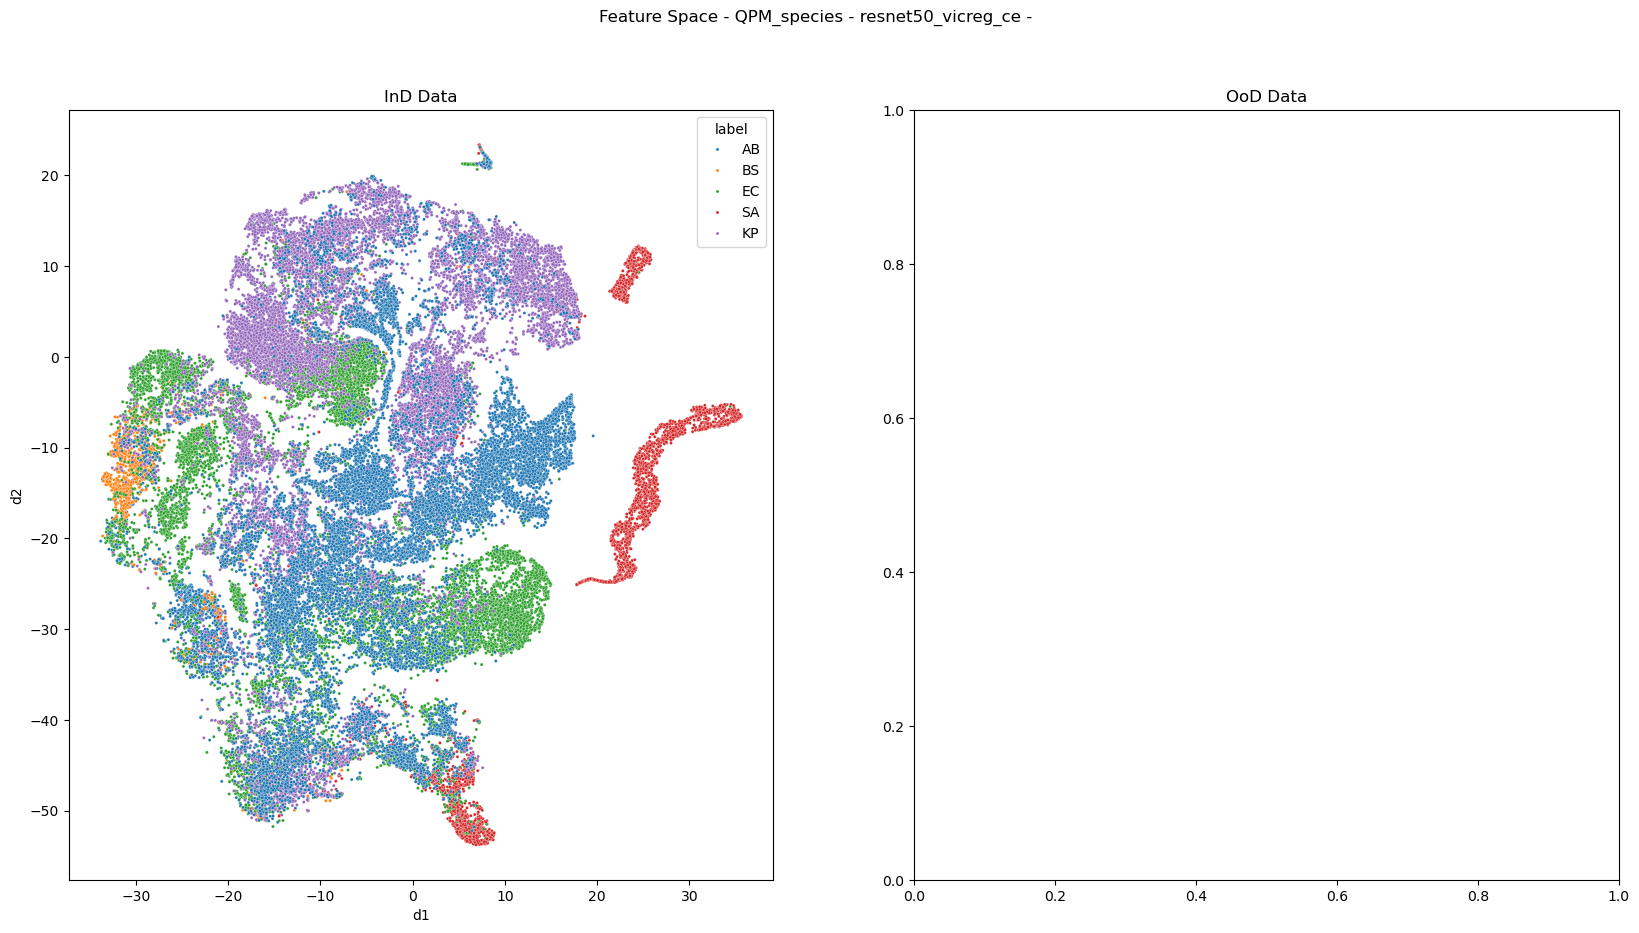

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

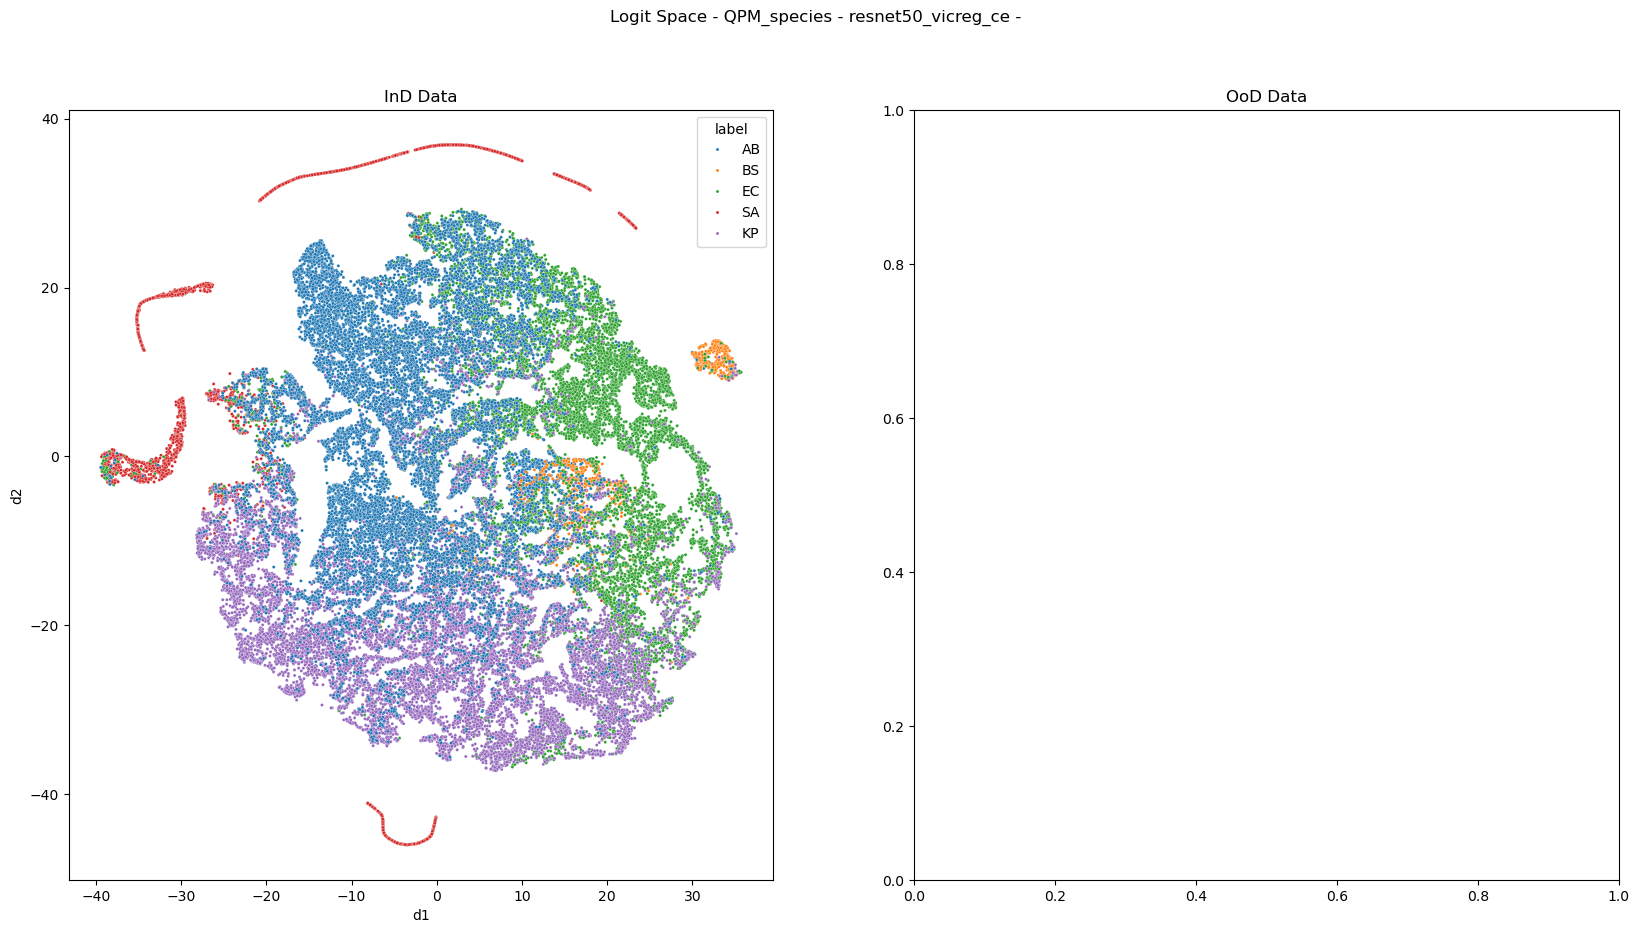

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [01:01<03:04, 61.45s/it]

 50%|████████████████████████████████████                                    | 2/4 [02:03<02:03, 61.54s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [03:05<01:01, 61.80s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [04:07<00:00, 62.21s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [04:07<00:00, 62.00s/it]

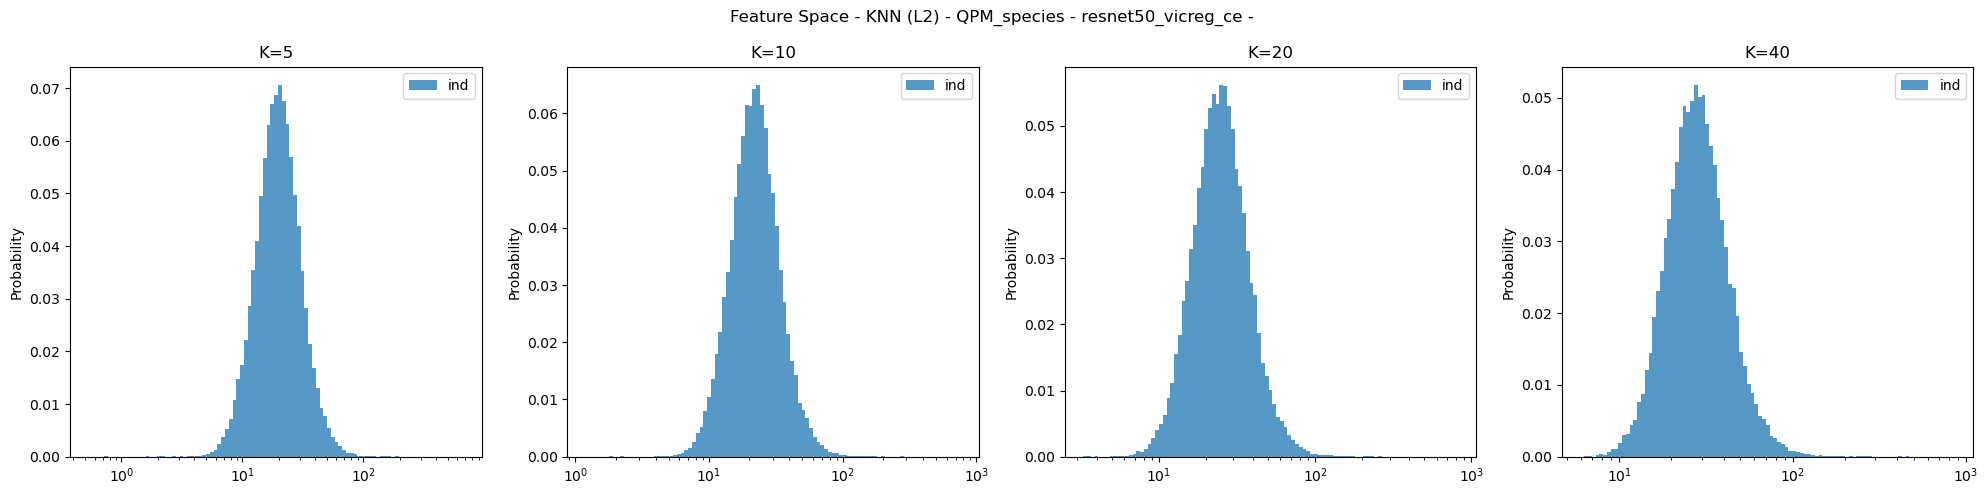

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [01:01<03:03, 61.32s/it]

 50%|████████████████████████████████████                                    | 2/4 [02:02<02:02, 61.13s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [03:03<01:01, 61.30s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [04:05<00:00, 61.62s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [04:05<00:00, 61.48s/it]

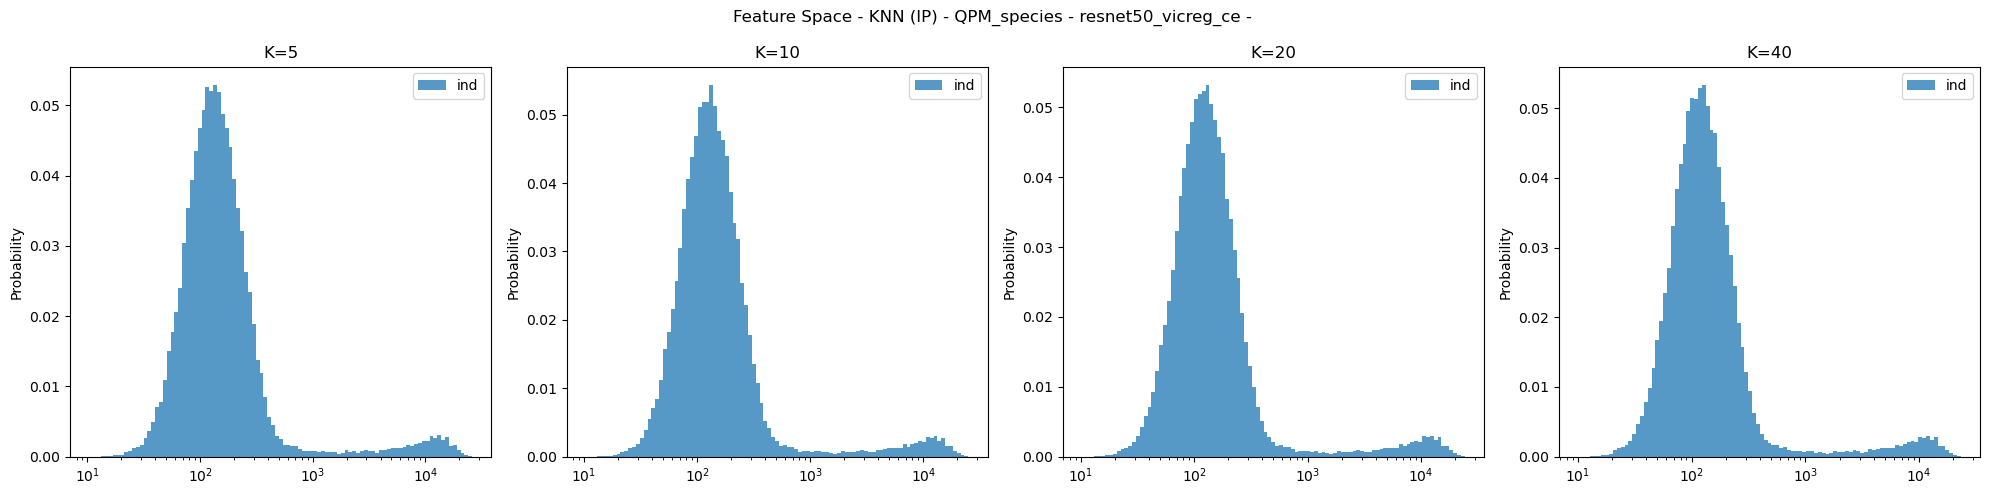

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:06,  2.24s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.29s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.38s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.57s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.48s/it]

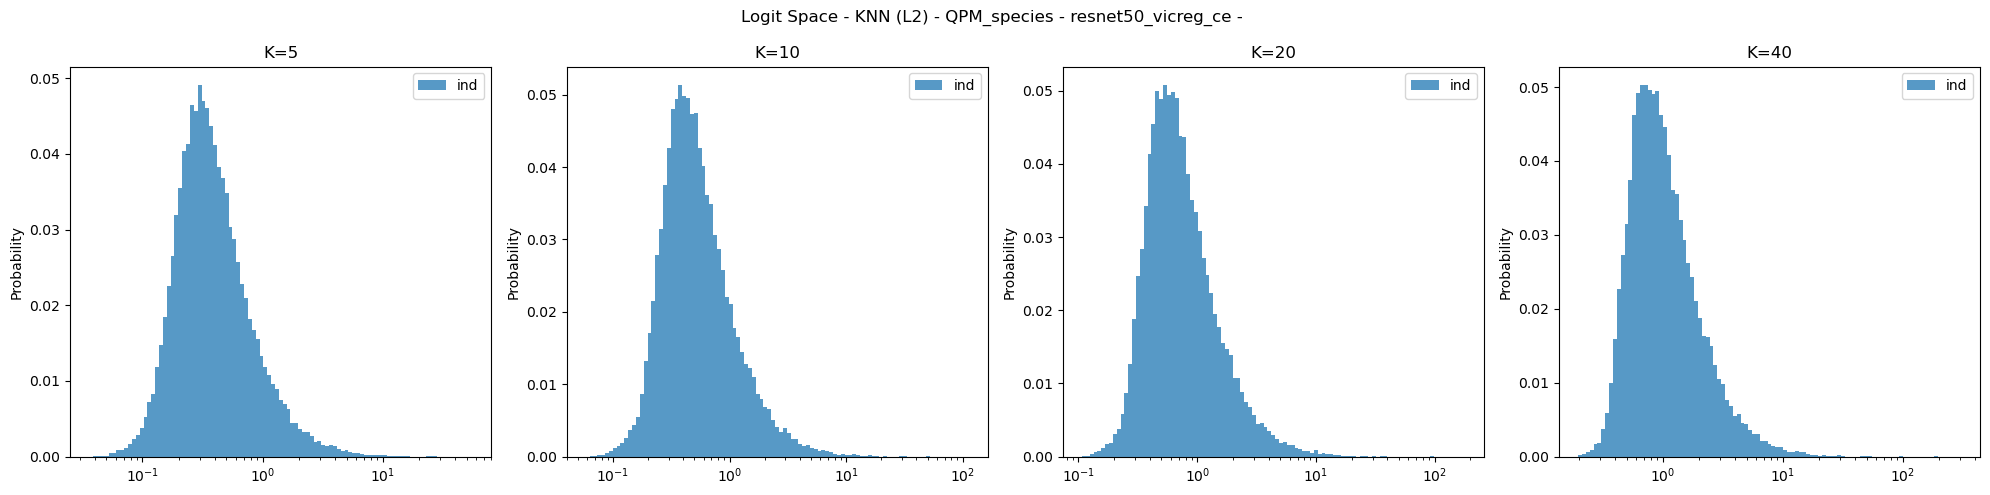

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  1.95s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  1.99s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.10s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.31s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.21s/it]

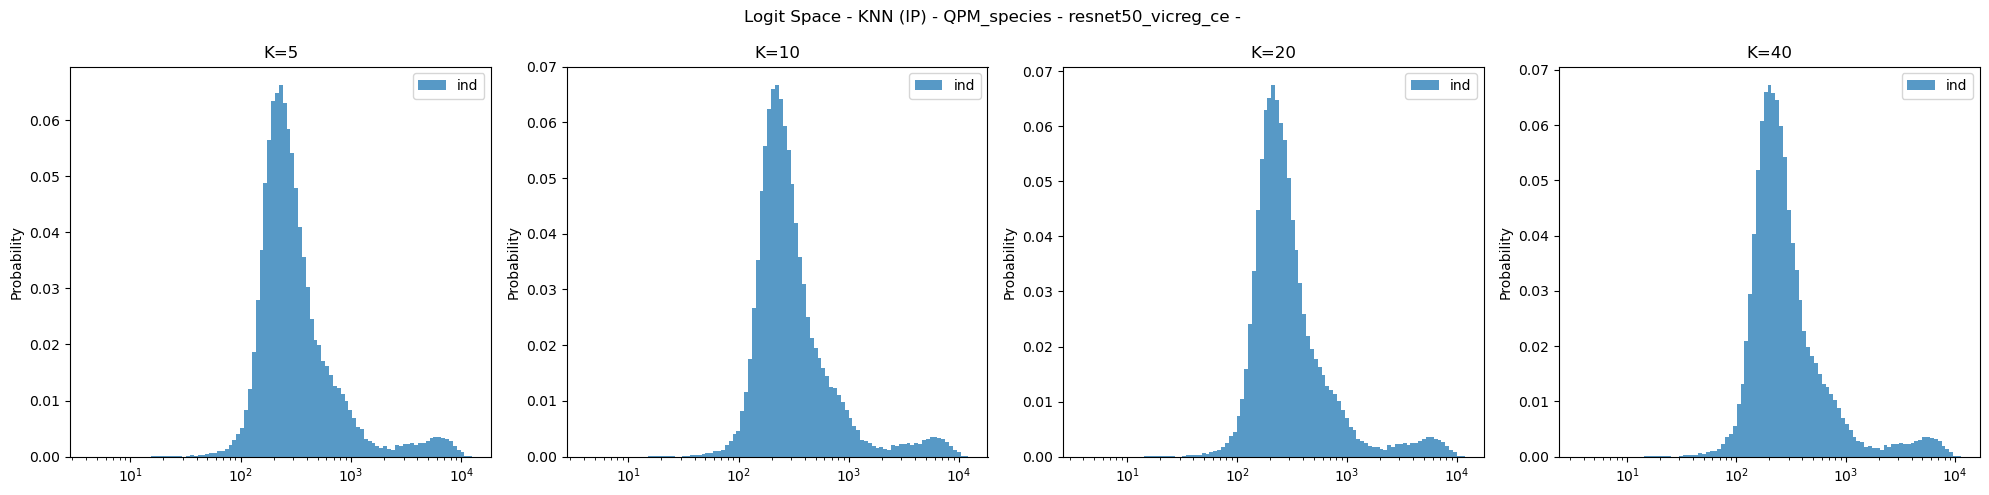

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

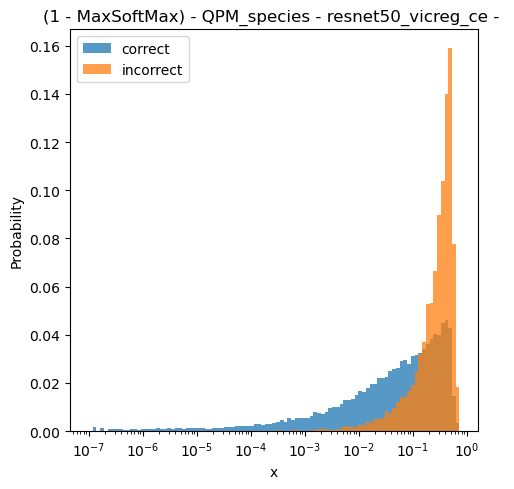

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()